In [4]:
!pip install igraph

  Obtaining dependency information for igraph from https://files.pythonhosted.org/packages/6f/6d/bb78f8ddb276b8fd424589ba27d28c2fb1ca4f62d394ca690403b4eb3082/igraph-0.11.3-cp39-abi3-win_amd64.whl.metadata
  Obtaining dependency information for texttable>=1.6.2 from https://files.pythonhosted.org/packages/24/99/4772b8e00a136f3e01236de33b0efda31ee7077203ba5967fcc76da94d65/texttable-1.7.0-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB 445.2 kB/s eta 0:00:06
   ---------------------------------------- 0.0/2.5 MB 445.2 kB/s eta 0:00:06
   ---------------------------------------- 0.0/2.5 MB 445.2 kB/s eta 0:00:06
    --------------------------------------- 0.1/2.5 MB 252.2 kB/s eta 0:00:10
   - -------------------------------------- 0.1/2.5 MB 350.1 kB/s eta 0:00:07
   - -------------------------------------- 0.1/2.5 M


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import pickle
import igraph as ig
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
import seaborn as sns


In [6]:
with open('data_preparation/kialo_data/1_raw_data/dumped_discussions_first.pickle', 'rb') as f:
    discussions = pickle.load(f)

In [3]:
with open('dumped_discussions_first.pickle', 'rb') as f:
    discussions = pickle.load(f)

In [ ]:
discussions

In [8]:
# Check the first few entries
first_few_discussions = discussions[:2]
first_few_discussions

[{'discussion': {'claims': [{'id': '333.0',
     'authorId': '0077c272-1fdc-4202-a06a-160482dfc12d',
     'created': 1382962412430,
     'version': 2,
     'text': 'Anonymous currency discussions',
     'lastModifiedForSitemaps': 1382962412430},
    {'id': '333.1',
     'authorId': '0077c272-1fdc-4202-a06a-160482dfc12d',
     'created': 1382962412434,
     'version': 4,
     'text': 'An anonymous untrackable digital currency \\(ADC\\), like Bitcoin, is beneficial for civilized societies.',
     'lastModifiedForSitemaps': 1382962412434},
    {'id': '333.2',
     'authorId': '0077c272-1fdc-4202-a06a-160482dfc12d',
     'created': 1382962534883,
     'version': 7,
     'text': "Cash is a necessary part of any functional society's economic model and cryptocurrencies are an easier and online-ready form of cash. They are the natural progression of what money is becoming in the digital age.",
     'lastModifiedForSitemaps': 1519262762906},
    {'id': '333.3',
     'authorId': '0077c272-1fdc-4

The JSON structure is converted to dataframes, which facilitates data analysis

# JSON Representation

In [4]:
# Initializing empty lists to store the flattened data
flattened_discussions = []
flattened_claims = []
flattened_positions = []

# Looping through each discussion to flatten the data structure
for discussion in discussions:
    # Extracting discussion-level attributes
    discussion_id = discussion.get("title", None)
    background_info = discussion.get("background info", None)

    # Appending to the discussion list
    flattened_discussions.append({
        'title': discussion_id,
        'background_info': background_info
    })

    # Looping through claims in each discussion
    claims = discussion.get("discussion", {}).get("claims", [])
    for claim in claims:
        claim['discussion_title'] = discussion_id  # Adding the discussion ID for reference
        flattened_claims.append(claim)

    # Looping through positions in each discussion
    positions = discussion.get("discussion", {}).get("locations", [])
    for position in positions:
        position['discussion_title'] = discussion_id  # Adding the discussion ID for reference
        flattened_positions.append(position)

# Converting the lists to Pandas DataFrames
df_discussions = pd.DataFrame(flattened_discussions)
df_claims = pd.DataFrame(flattened_claims)
df_positions = pd.DataFrame(flattened_positions)

# Showing the first few rows of each DataFrame to check the structure (TODO add diagram to show this relations)
print("discussions \n")
print()
print(df_discussions.head())
print("claims \n")
print()
print(df_claims.head())
print("positions \n")
print()
print(df_positions.head())

discussions 


                                               title  \
0  Are Bitcoin and Similar Cryptocurrencies Good ...   
1             Should we Have a 100% Inheritance Tax?   
2  Autonomous Killing Machines: The Future of War...   
3  Is Capital Punishment in the United States jus...   
4  The world would be better off without organize...   

                                     background_info  
0  In recent years, a surge in its value catapult...  
1  The lottery of birth is sometimes very literal...  
2  Should the West build military killer robots? ...  
3  Capital punishment, or the death penalty, has ...  
4                                                     
claims 


      id                              authorId        created  version  \
0  333.0  0077c272-1fdc-4202-a06a-160482dfc12d  1382962412430        2   
1  333.1  0077c272-1fdc-4202-a06a-160482dfc12d  1382962412434        4   
2  333.2  0077c272-1fdc-4202-a06a-160482dfc12d  1382962534883        7   
3  333.3  00

## Understand Data Structure

### 1. df_discussions
The DataFrame `df_discussions` contains titles and background information for each discussion.

**Columns:**
- `title`: Title of the discussion.
- `background_info`: Additional context or background information related to the discussion.

### 2. df_claims
The DataFrame `df_claims` contains the claims and associated metadata.

**Columns:**
- `id`: ID of the claim. The number behind the decimal place refers to the claim id  (0.0 => claim 0 in discussion 0, 0.1 => claim 1 in discussion 1)
- `authorId`: ID of the claim's author.
- `created`: Timestamp when the claim was created.
- `version`: Number of times the claim has been edited.
- `text`: Text content of the claim.
- `lastModifiedForSitemaps`: Timestamp of the last modification.
- `discussion_title`: Title of the discussion to which the claim belongs.
- `flag`: Metadata related to the claim (e.g. Unsupported, Not a claim, etc.).
- `copierId`: ID of the user who copied the claim (if applicable).
- `accepterId`: ID of the user who accepted the claim (if applicable).
- `discussionLinkTo`: Link to the discussion to which the claim belongs (if applicable).

### 3. df_positions
The DataFrame `df_positions` contains the positions (or locations) and associated metadata. It captures the relationships (PRO or CON) between claims, indicating which claim is a response to another and if it´s supporting it or not.

**Columns:**
- `id`: ID of the position.
- `targetId`: ID of the target claim.
- `version`: Number of times the position has been edited.
- `isOrigin`: Boolean value indicating whether the position is the origin of the discussion.
- `authorId`: ID of the position's author.
- `created`: Timestamp when the position was created.
- `parentId`: ID of the parent claim.
- `relation`: Stance type (Pro or Con).
- `isDeleted`: Boolean value indicating whether the position is deleted.
- `lastModifiedForSitemaps`: Timestamp of the last modification.
- `discussion_title`: Title of the discussion to which the position belongs.
- `flag`: Metadata related to the position (e.g. Unsupported, Not a position, etc.).
- `copierId`: ID of the user who copied the position (if applicable).
- `accepterId`: ID of the user who accepted the position (if applicable).


### Types of Marks (Flags)

According to [Kialo's support page](https://support.kialo.com/en/hc/types-of-mark/), there are 8 different types of marks (or flags) that can be used when marking a claim for review. A claim can be marked (or flagged) with up to 2 different types of mark at a time.

1. **Unsupported**: The claim lacks evidence, either in the form of linked sources or explanatory Pros underneath it.
2. **Not a claim**: A claim must be making an argument, arguing for or against the claim or thesis located above it. Anything that does not do so is not adding to the argument at hand, and therefore is not a claim; this mark is used to point out that problem.
3. **Unclear**: This mark should be used to indicate that the user marking the claim does not understand the meaning of the claim or some aspect of it, or doubts that other readers are able to easily do so.
4. **Vulgar/abusive**: This claim is insulting, overly offensive, or unnecessarily vulgar in expression. Kialo aims to provide the greatest degree of freedom of expression, but this should not be misused to attack or insult others – this mark is used to draw an Admin’s attention to serious misuse of the platform.
5. **Duplicate claim**: The claim repeats another existing claim in the discussion, either in part or in full. This often happens accidentally, when the same claim is created twice or when a claim restates its parent using different wording, consequently not adding anything new to the discussion.
6. **Unrelated**: While the claim is an argument, it does not make a logical connection to its parent, either supporting or attacking it. Therefore, it is potentially irrelevant in its current location.
7. **More than one claim**: The claim contains content that should probably be split into multiple claims.
8. **Move elsewhere**: The claim would fit better at a different location. This mark clears automatically if the claim is moved.

## Data Cleaning (1)
### Selecting Columns
- `copierId` , `accepterId` and `discussionLinkTo` of positions and claims dataframes have been removed for now cause they do not provide an obvious benefit to understanding the flow of a conversation.
- Also the df_claims_clean etc. do not contain isOrigin and versions of positions which have been added in this new version since they can provide information about recency and about location.

In [5]:
# Keeping relevant columns
df_claims_clean = df_claims[
    ['id', 'authorId', 'created', 'text', 'version', 'flag', 'lastModifiedForSitemaps', 'discussion_title']]
df_positions_clean = df_positions[
    ['id', 'authorId', 'created', 'version', 'isOrigin', 'parentId', 'targetId', 'relation', 'isDeleted',
     'lastModifiedForSitemaps', 'discussion_title']]

# Filtering out deleted positions
df_positions_clean = df_positions_clean[df_positions_clean['isDeleted'] == False]

### Renaming Columns

The column names of the `df_claims_clean` and `df_positions_clean` DataFrames are being updated for better understanding.

#### df_claims_clean

The following columns in `df_claims_clean` DataFrame are renamed such that we can distinguish attribute names between positions and claims easily:

- `id` is renamed to `claimId`
- `created` is renamed to `claimCreated`
- `text` is renamed to `claimText`
- `lastModifiedForSitemaps` is renamed to `lastModified`: This change simplifies the column name to what is relevant for the thesis.


#### df_positions_clean

The following columns in `df_positions_clean` DataFrame are renamed:

- `id` is renamed to `positionId`
- `targetId` is renamed to `sourceClaimId`
- `parentId` is renamed to `targetClaimId`
- `relation` is renamed to `stanceType`: This change clarifies whether a claim is Pro (1) or Con (-1) in relation to its parent.
- `lastModifiedForSitemaps` is renamed to `lastModified`

In [6]:

# Renaming the columns for better clarity
df_claims_clean = df_claims_clean.rename(columns={
    'id': 'claimId',
    'created': 'claimCreated',
    'text': 'claimText',
    'lastModifiedForSitemaps': 'lastModified'
})

df_positions_clean = df_positions_clean.rename(columns={
    'id': 'positionId',
    'targetId': 'sourceClaimId',
    'parentId': 'targetClaimId',
    'relation': 'stanceType',
    'lastModifiedForSitemaps': 'lastModified'
})

df_claims_clean.head(), df_positions_clean.head()

(  claimId                              authorId   claimCreated  \
 0   333.0  0077c272-1fdc-4202-a06a-160482dfc12d  1382962412430   
 1   333.1  0077c272-1fdc-4202-a06a-160482dfc12d  1382962412434   
 2   333.2  0077c272-1fdc-4202-a06a-160482dfc12d  1382962534883   
 3   333.3  0077c272-1fdc-4202-a06a-160482dfc12d  1382962630371   
 4   333.4  0077c272-1fdc-4202-a06a-160482dfc12d  1382962663127   
 
                                            claimText  version flag  \
 0                     Anonymous currency discussions        2  NaN   
 1  An anonymous untrackable digital currency \(AD...        4  NaN   
 2  Cash is a necessary part of any functional soc...        7  NaN   
 3  Most ordinary citizens would not use such a cu...        5  NaN   
 4  Most people pay taxes and banks report all the...        4  NaN   
 
     lastModified                                   discussion_title  
 0  1382962412430  Are Bitcoin and Similar Cryptocurrencies Good ...  
 1  1382962412434  Are Bit

## Timestamps

In [37]:
df_claims_clean_with_features = df_claims_clean 
#df_claims_clean_with_features = pd.read_csv(
    #"data_preparation/kialo_data/2_cleaned_data_JSON/df_claims_clean_with_features.csv")


In [38]:
df_claims_clean_with_features.head()

,claimId,authorId,claimCreated,version,claimText,lastModified,discussion_title,flag,copierId,accepterId,discussionLinkTo
0,333.0,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412430,2,Anonymous currency discussions,1382962412430,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
1,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,4,An anonymous untrackable digital currency \(AD...,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
2,333.2,0077c272-1fdc-4202-a06a-160482dfc12d,1382962534883,7,Cash is a necessary part of any functional soc...,1519262762906,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
3,333.3,0077c272-1fdc-4202-a06a-160482dfc12d,1382962630371,5,Most ordinary citizens would not use such a cu...,1576178856169,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
4,333.4,0077c272-1fdc-4202-a06a-160482dfc12d,1382962663127,4,Most people pay taxes and banks report all the...,1522998749892,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN


In [39]:
# Convert Unix timestamps to human-readable date-time format
df_claims_clean_with_features['claimCreated_readable'] = pd.to_datetime(df_claims_clean_with_features['claimCreated'],
                                                                        unit='ms')
df_claims_clean_with_features['lastModified_readable'] = pd.to_datetime(df_claims_clean_with_features['lastModified'],
                                                                        unit='ms')
df_positions_clean['lastModified_readable'] = pd.to_datetime(df_positions_clean['lastModified'], unit='ms')


In [ ]:
# Save the updated DataFrames for future use
df_claims_clean_with_features.to_csv('data_preparation/kialo_data/2_cleaned_data_JSON', index=False)
df_positions_clean.to_csv('data_preparation/kialo_data/2_cleaned_data_JSON', index=False)


#### Flags
Flags contain multiple types, often with a 'reason' attached.

In [74]:
# Count non-NaN values in 'flag' column
non_nan_count = df_claims_clean['flag'].count()

# Total number of values in 'df_claims'
total_count = df_claims.shape[0]  # Assuming you want to count rows

# Calculate the ratio
ratio = non_nan_count / total_count

# Print the results
print("Count of non-NaN values in 'flag' column:", non_nan_count)
print("Total number of values in 'df_claims':", total_count)
print("Ratio of non-NaN values to total values:", ratio)



Count of non-NaN values in 'flag' column: 22721
Total number of values in 'df_claims': 679485
Ratio of non-NaN values to total values: 0.03343856008594744


In [40]:
# Converting the 'flag' column to a string representation to handle unhashable types like dictionaries
df_claims_clean['flag_str'] = df_claims_clean['flag'].astype(str)

# Checking unique flag types
unique_flags = df_claims_clean['flag_str'].unique()
print(unique_flags)

['nan'
 "{'flagType': 3, 'reason': 'see comments, also seems to be unrelated'}"
 "{'flagType': 1, 'reason': ''}" ...
 "{'flagType': 1, 'reason': 'This is written as a personal experience. It would work better if it was written as a nonpersonal statement.'}"
 "{'flagType': 0, 'reason': 'Needs a source as suggested in the comments.'}"
 "{'flagType': 0, 'reason': 'marking as a reminder to find a source'}"]


## Feature Engineering

In this section, the `version` and `lastModified` features in the df_claims_clean DataFrame are analyzed because they both provide information about time.


In [41]:
# Analyzing 'version' and 'lastModified' further
version_stats = df_claims_clean['version'].describe()
last_modified_stats = df_claims_clean['lastModified'].describe()
print(version_stats)
print()
print(last_modified_stats)

count    679485.000000
mean          1.802965
std           1.327406
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          46.000000
Name: version, dtype: float64

count    6.794850e+05
mean     1.559772e+12
std      4.513152e+10
min      1.380182e+12
25%      1.524335e+12
50%      1.560927e+12
75%      1.595252e+12
max      1.634713e+12
Name: lastModified, dtype: float64


### Observations for Time Features

#### Version
- Count: 679,485
- Mean: ~1.8
- Max: 46

Most claims have a version number around 1-2, indicating that many claims are not modified multiple times.

#### Last Modified

TODO : Change to readable format

- Mean Timestamp: ~1.56e12  
- Max Timestamp: ~1.63e12

The `lastModified` feature varies significantly, which could be useful for recency information.

#### RecencyComplexity Score

The 75th percentile is a robust normalization factor, reducing outlier influence and balancing between median and maximum. It ensures exceptional cases stand out without losing crucial data.

Before applying this normalization, it's important to verify that it won't eliminate important data. This can be done by plotting the distribution of the data before and after applying the normalization:

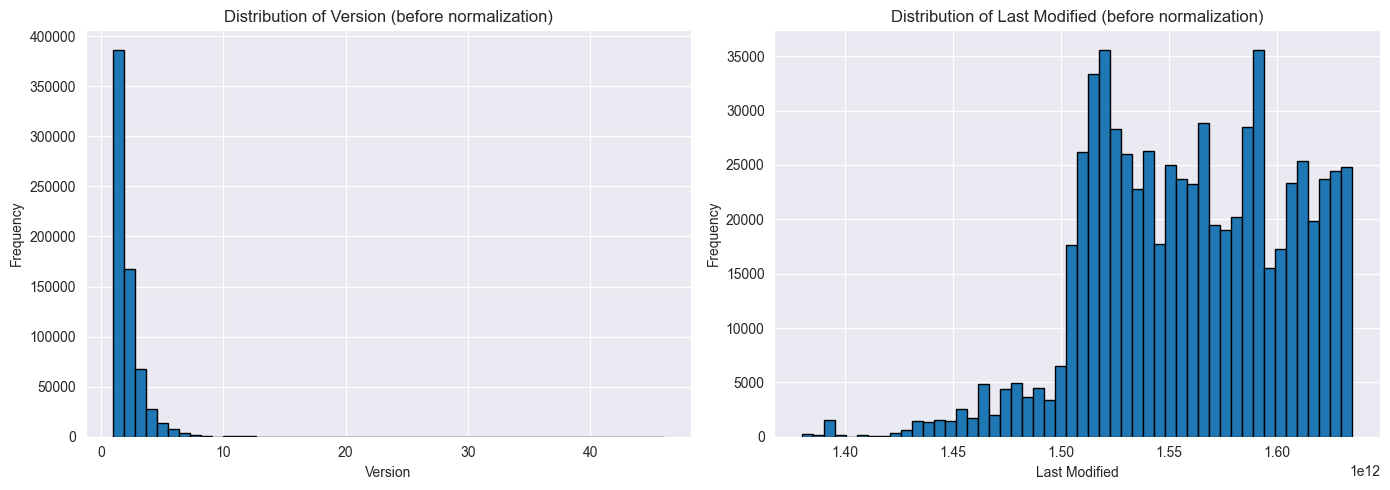

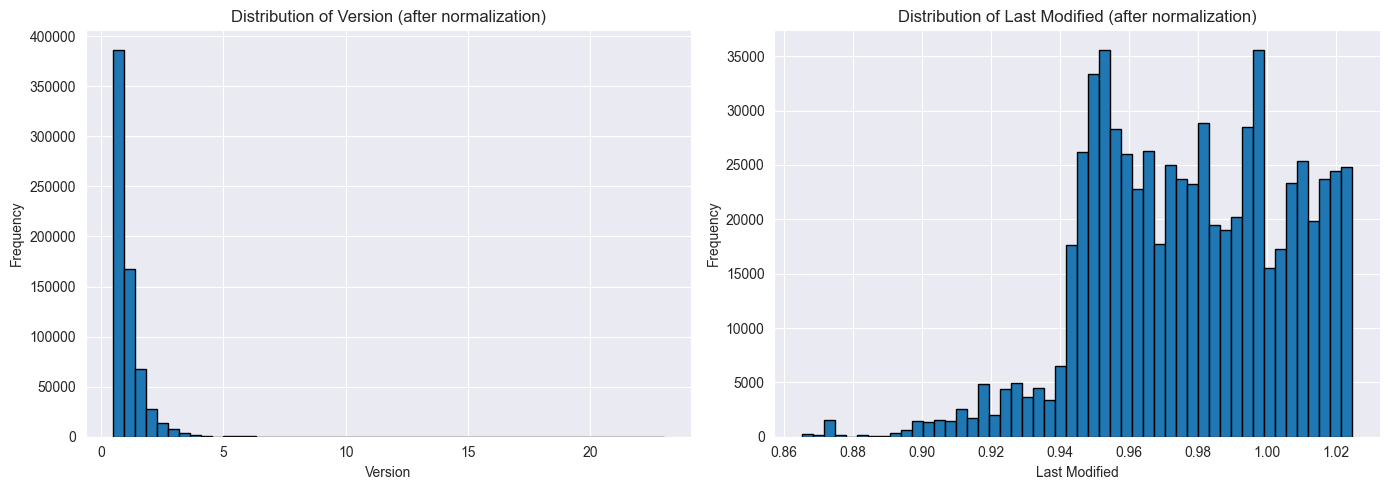

In [42]:
# Plot before normalization
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(df_claims_clean['version'], bins=50, edgecolor='black')
axs[0].set_title('Distribution of Version (before normalization)')
axs[0].set_xlabel('Version')
axs[0].set_ylabel('Frequency')

axs[1].hist(df_claims_clean['lastModified'], bins=50, edgecolor='black')
axs[1].set_title('Distribution of Last Modified (before normalization)')
axs[1].set_xlabel('Last Modified')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate the 75th percentile for 'version' and 'lastModified'
version_75th_percentile = df_claims_clean['version'].quantile(0.75)
last_modified_75th_percentile = df_claims_clean['lastModified'].quantile(0.75)

# Normalize 'version' and 'lastModified' using the 75th percentile
df_claims_clean['version_normalized'] = df_claims_clean['version'] / version_75th_percentile
df_claims_clean['lastModified_normalized'] = df_claims_clean['lastModified'] / last_modified_75th_percentile

# Plot after normalization
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(df_claims_clean['version_normalized'], bins=50, edgecolor='black')
axs[0].set_title('Distribution of Version (after normalization)')
axs[0].set_xlabel('Version')
axs[0].set_ylabel('Frequency')

axs[1].hist(df_claims_clean['lastModified_normalized'], bins=50, edgecolor='black')
axs[1].set_title('Distribution of Last Modified (after normalization)')
axs[1].set_xlabel('Last Modified')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looks like the majority of the data was not cut off.

In [26]:
df_claims_clean.head()

,id,authorId,created,version,text,lastModifiedForSitemaps,discussion_title,flag,copierId,accepterId,discussionLinkTo
0,333.0,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412430,2,Anonymous currency discussions,1382962412430,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
1,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,4,An anonymous untrackable digital currency \(AD...,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
2,333.2,0077c272-1fdc-4202-a06a-160482dfc12d,1382962534883,7,Cash is a necessary part of any functional soc...,1519262762906,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
3,333.3,0077c272-1fdc-4202-a06a-160482dfc12d,1382962630371,5,Most ordinary citizens would not use such a cu...,1576178856169,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
4,333.4,0077c272-1fdc-4202-a06a-160482dfc12d,1382962663127,4,Most people pay taxes and banks report all the...,1522998749892,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN


## Data Exploration

### Subset 1 ('RecencyComplexityScore', 'NumFlags', 'claimCreated', 'version', 'lastModified')

TODO: Subset 2 and 3

In [ ]:
# Reload the saved DataFrame with new features to continue with the analysis
#df_claims_clean = pd.read_csv('./data_preparation/kialo_data/2_cleaned_data_JSON/df_claims_clean_with_features.csv')

# Perform the descriptive statistics on a smaller subset of the data to avoid computational issues
desc_stats_subset = df_claims_clean.sample(frac=0.1, random_state=42)[
    ['RecencyComplexityScore', 'NumFlags', 'claimCreated', 'version', 'lastModified']].describe()

# Calculate correlations between the features on the same subset
correlations_subset = df_claims_clean.sample(frac=0.1, random_state=42)[
    ['RecencyComplexityScore', 'NumFlags', 'claimCreated', 'version', 'lastModified']].corr()

print("description of statistics")
print()
print(desc_stats_subset)
print()
print("correlations of variables ")
print()
print(correlations_subset)


#### Heat Maps

In [ ]:


# Set up the matplotlib figure
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18, 12))

# Plotting distribution plots for continuous features
sns.histplot(df_claims_clean['RecencyComplexityScore'], kde=True, ax=axs[0, 0]).set_title(
    #'Distribution of Recency-Complexity Score')
sns.histplot(df_claims_clean['NumFlags'], kde=True, ax=axs[0, 1]).set_title('Distribution of Number of Flags')
sns.histplot(df_claims_clean['claimCreated'], kde=True, ax=axs[0, 2]).set_title(
    'Distribution of Claim Created Timestamps')
sns.histplot(df_claims_clean['version'], kde=True, ax=axs[1, 0]).set_title('Distribution of Version')
sns.histplot(df_claims_clean['lastModified'], kde=True, ax=axs[1, 1]).set_title(
    'Distribution of Last Modified Timestamps')

# Plotting heatmap for correlations
sns.heatmap(correlations_subset, annot=True, cmap='coolwarm', ax=axs[1, 2]).set_title('Heatmap of Feature Correlations')

# Tight layout
plt.tight_layout()

In [ ]:
# Save the plot
eda_plot_path = 'data_preparation/kialo_data/4_diagram_files/eda_plots.png'
plt.savefig(eda_plot_path)
plt.show()
eda_plot_path

#### Exploratory Data Analysis (EDA) Findings

##### Distribution Plots

- **Recency-Complexity Score:** Majority are close to 1; some outliers exist.
- **Number of Flags:** Most claims have zero or few flags.
- **Claim Created Timestamps:** Broad distribution, possibly related to the age of the claim.
- **Version:** Most claims have a version close to 1, with a few outliers.
- **Last Modified Timestamps:** Similar to 'Claim Created', indicating that claims are not that often modified after have been created.

##### Heatmap of Feature Correlations

There is a moderate correlation between 'ClaimCreated' and 'LastModified', confirming that the date, when the claim was created is mostly also the date, when it was last modified. This is supported by the observation that most claims have only 1 version (which is the 1st and last).

##### Observations & Assumptions

- The distribution plots indicate that our data is mostly concentrated around lower values for features like 'RecencyComplexityScore' and 'NumFlags'.
- The heatmap ***confirms that most features are not highly correlated, making them useful for further analysis***.

### Heatmap of all Features

In [54]:
df_positions.head()

,id,targetId,version,isOrigin,authorId,created,parentId,relation,isDeleted,lastModifiedForSitemaps,discussion_title,flag,copierId,accepterId
0,333.1137,333.0,1,True,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412430,None,NaN,False,1382962412430,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN
1,333.1264,333.1,2,True,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,333.0,0.0,True,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN
2,333.192,333.2,1,True,0077c272-1fdc-4202-a06a-160482dfc12d,1382962534884,333.1,1.0,False,1382962534884,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN
3,333.194,333.3,1,True,0077c272-1fdc-4202-a06a-160482dfc12d,1382962630372,333.1,-1.0,False,1382962630372,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN
4,333.196,333.5,3,True,0077c272-1fdc-4202-a06a-160482dfc12d,1382962685770,333.2,-1.0,True,1382962685770,Are Bitcoin and Similar Cryptocurrencies Good ...,"{'flagType': 8, 'reason': ''}",NaN,NaN


In [55]:
df_claims.head()

,id,authorId,created,version,text,lastModifiedForSitemaps,discussion_title,flag,copierId,accepterId,discussionLinkTo
0,333.0,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412430,2,Anonymous currency discussions,1382962412430,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
1,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,4,An anonymous untrackable digital currency \(AD...,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
2,333.2,0077c272-1fdc-4202-a06a-160482dfc12d,1382962534883,7,Cash is a necessary part of any functional soc...,1519262762906,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
3,333.3,0077c272-1fdc-4202-a06a-160482dfc12d,1382962630371,5,Most ordinary citizens would not use such a cu...,1576178856169,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN
4,333.4,0077c272-1fdc-4202-a06a-160482dfc12d,1382962663127,4,Most people pay taxes and banks report all the...,1522998749892,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,NaN,NaN,NaN


In [9]:


df_claims = pd.read_csv(
    './data_preparation/kialo_data/2_cleaned_data_JSON/df_claims_clean_with_readable_timestamps.csv')
df_positions = pd.read_csv(
    './data_preparation/kialo_data/2_cleaned_data_JSON/df_positions_clean_with_readable_timestamps.csv')
# Load the cleaned DataFrames with readable timestamps
df_claims_clean = df_claims
df_positions_clean = df_positions

# Merge the two DataFrames on 'claimId' and 'targetClaimId'
df_merged = pd.merge(df_claims_clean, df_positions_clean, left_on='claimId', right_on='targetClaimId', how='left')

# Drop redundant columns
if 'discussionTitle_x' in df_merged.columns and 'discussionTitle_y' in df_merged.columns:
    if df_merged['discussionTitle_x'].equals(df_merged['discussionTitle_y']):
        df_merged.drop(['discussionTitle_y'], axis=1, inplace=True)

# Remove missing values for the analysis
df_merged.dropna(subset=['claimId', 'authorId', 'claimText', 'stanceType'], inplace=True)

# Group by 'authorId' to get the number of claims per author
claims_per_author = df_merged['authorId'].value_counts()

# Group by 'discussionTitle_x' to get the number of claims per topic
claims_per_topic = df_merged['discussionTitle_x'].value_counts()

# Calculate the depth of discussions
# We assume the depth is represented by the number of related claims to a parent claim
depth_of_claims = df_merged['targetClaimId'].value_counts()

# Return some basic statistics
claims_per_author.describe(), claims_per_topic.describe(), depth_of_claims.describe()


(count    24736.000000
 mean        34.231444
 std        252.729469
 min          1.000000
 25%          2.000000
 50%          5.000000
 75%         15.000000
 max      15656.000000
 Name: count, dtype: float64,
 count    10758.000000
 mean        78.708775
 std        369.848002
 min          1.000000
 25%          5.000000
 50%         16.000000
 75%         42.000000
 max      19700.000000
 Name: count, dtype: float64,
 count    225716.000000
 mean          3.751391
 std           6.746497
 min           1.000000
 25%           1.000000
 50%           2.000000
 75%           4.000000
 max         464.000000
 Name: count, dtype: float64)

In [77]:
df_merged.head()

,claimId,authorId,claimCreated,claimText,version,flag,lastModified_x,discussionTitle_x,flag_str,RecencyComplexityScore,...,claimCreated_readable,lastModified_readable_x,positionId,sourceClaimId,targetClaimId,stanceType,isDeleted,lastModified_y,discussionTitle_y,lastModified_readable_y
0,333.0,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412430,Anonymous currency discussions,2,NaN,1382962412430,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,0.933462,...,2013-10-28 12:13:32.430,2013-10-28 12:13:32.430,333.126,333.167,333.0,0.0,False,1.520097e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2018-03-03 17:08:07.014
1,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,An anonymous untrackable digital currency \(AD...,4,NaN,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,1.433462,...,2013-10-28 12:13:32.434,2013-10-28 12:13:32.434,333.192,333.200,333.1,1.0,False,1.382963e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:15:34.884
2,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,An anonymous untrackable digital currency \(AD...,4,NaN,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,1.433462,...,2013-10-28 12:13:32.434,2013-10-28 12:13:32.434,333.194,333.300,333.1,-1.0,False,1.382963e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:17:10.372
3,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,An anonymous untrackable digital currency \(AD...,4,NaN,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,1.433462,...,2013-10-28 12:13:32.434,2013-10-28 12:13:32.434,333.202,333.120,333.1,-1.0,False,1.382963e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:22:59.958
4,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,An anonymous untrackable digital currency \(AD...,4,NaN,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,1.433462,...,2013-10-28 12:13:32.434,2013-10-28 12:13:32.434,333.205,333.170,333.1,1.0,False,1.382963e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:30:16.087


In [78]:
df_merged.columns

Index(['claimId', 'authorId', 'claimCreated', 'claimText', 'version', 'flag',
       'lastModified_x', 'discussionTitle_x', 'flag_str',
       'RecencyComplexityScore', 'NumFlags', 'claimCreated_readable',
       'lastModified_readable_x', 'positionId', 'sourceClaimId',
       'targetClaimId', 'stanceType', 'isDeleted', 'lastModified_y',
       'discussionTitle_y', 'lastModified_readable_y'],
      dtype='object')

In [107]:
df_merged.describe()

,claimId,claimCreated,version,lastModified_x,RecencyComplexityScore,NumFlags,positionId,sourceClaimId,targetClaimId,stanceType,lastModified_y
count,746630.000000,7.466300e+05,746630.000000,7.466300e+05,746630.000000,746630.000000,746630.000000,746630.000000,746630.000000,746630.000000,7.466300e+05
mean,18209.652652,1.539926e+12,2.140781,1.552330e+12,1.021742,0.057557,18209.695639,18209.702794,18209.652652,-0.014284,1.552611e+12
std,15097.847276,4.281401e+10,1.748227,4.567525e+10,0.437554,0.361388,15097.853500,15097.848404,15097.847276,0.994010,4.367020e+10
min,333.000000,1.380182e+12,1.000000,1.380182e+12,0.682591,0.000000,333.100100,333.100000,333.000000,-1.000000,1.380182e+12
25%,4628.200400,1.513271e+12,1.000000,1.518877e+12,0.737228,0.000000,4628.277525,4628.182100,4628.200400,-1.000000,1.520471e+12
50%,14272.300000,1.531316e+12,2.000000,1.549778e+12,0.968675,0.000000,14272.625500,14272.335500,14272.300000,-1.000000,1.549694e+12
75%,29946.630000,1.566752e+12,3.000000,1.587590e+12,1.221388,0.000000,29946.236750,29946.517500,29946.630000,1.000000,1.586174e+12
max,54034.300000,1.634713e+12,46.000000,1.634713e+12,11.983619,10.000000,54034.400000,54034.500000,54034.300000,1.000000,1.634713e+12


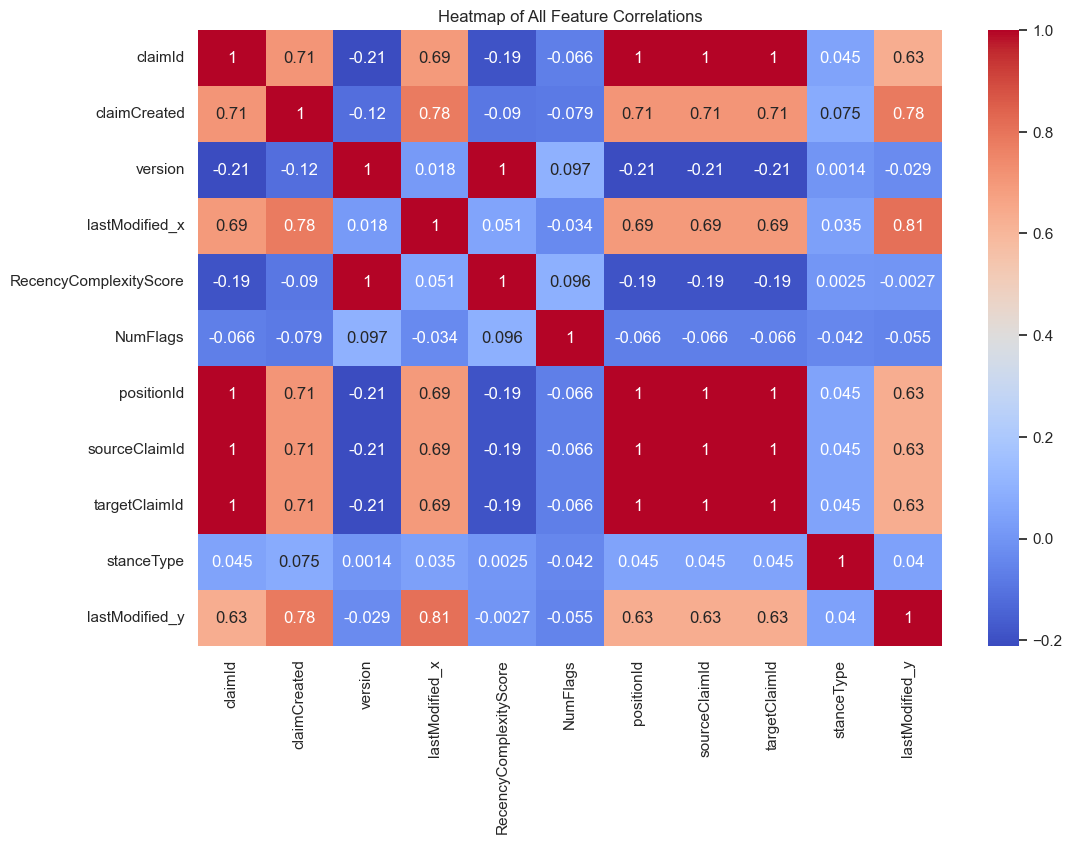

In [108]:
numeric_df = df_merged.select_dtypes(include=[np.number])

# Alternatively, if you know the specific columns to drop, you can do so by name
# numeric_df = df_merged.drop(columns=['column_name1', 'column_name2', ...])

# Calculating correlations between all numeric features
all_features_correlations = numeric_df.corr()

# Plotting the heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(all_features_correlations, annot=True, cmap='coolwarm')
plt.title("Heatmap of All Feature Correlations")

# Saving plots
heatmap_path = 'all_features_heatmap.png'
plt.savefig(heatmap_path)

# Display the heatmap
plt.show()

In [ ]:


# Plotting the heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(all_features_correlations, annot=True, cmap='coolwarm')
plt.title("Heatmap of All Feature Correlations")

# Saving plots
heatmap_path = 'data_preparation/kialo_data/4_diagram_files/all_features_heatmap.png'
#plt.savefig(heatmap_path)

heatmap_path

### Per Author Boxplots and Histplots


In [12]:
# Load the cleaned DataFrames with readable timestamps
df_claims_clean = pd.read_csv('data_preparation/kialo_data/2_cleaned_data_JSON/df_claims_clean_with_readable_timestamps.csv')
df_positions_clean = pd.read_csv('data_preparation/kialo_data/2_cleaned_data_JSON/df_positions_clean_with_readable_timestamps.csv')


In [62]:
df_positions_clean

,positionId,sourceClaimId,targetClaimId,stanceType,isDeleted,lastModified,discussionTitle,lastModified_readable
0,333.1137,333.00,NaN,NaN,False,1382962412430,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:13:32.430
1,333.1920,333.20,333.1,1.0,False,1382962534884,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:15:34.884
2,333.1940,333.30,333.1,-1.0,False,1382962630372,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:17:10.372
3,333.1405,333.70,333.3,1.0,False,1382962829538,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:20:29.538
4,333.2020,333.12,333.1,-1.0,False,1382962979958,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:22:59.958
...,...,...,...,...,...,...,...,...
650538,46616.1000,46616.11,46616.3,1.0,False,1613057230615,Deberían existir las redes de pesca?,2021-02-11 15:27:10.615
650539,46618.1000,46618.00,NaN,NaN,False,1613058685827,Salesforce FSL-201 Dumps PDF | FSL-201 Practic...,2021-02-11 15:51:25.827
650540,46618.2000,46618.30,46618.0,0.0,False,1613058685854,Salesforce FSL-201 Dumps PDF | FSL-201 Practic...,2021-02-11 15:51:25.854
650541,46620.1000,46620.00,NaN,NaN,False,1613059125313,Freeoracledumps.com | Get 1z0-997-20 Test Ques...,2021-02-11 15:58:45.313


In [64]:
df_positions_clean[df_positions_clean["isDeleted"] == True]

,positionId,sourceClaimId,targetClaimId,stanceType,isDeleted,lastModified,discussionTitle,lastModified_readable


In [67]:
df_merged.head()

,claimId,authorId,claimCreated,claimText,version,flag,lastModified_x,discussionTitle_x,flag_str,RecencyComplexityScore,...,claimCreated_readable,lastModified_readable_x,positionId,sourceClaimId,targetClaimId,stanceType,isDeleted,lastModified_y,discussionTitle_y,lastModified_readable_y
0,333.0,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412430,Anonymous currency discussions,2,NaN,1382962412430,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,0.933462,...,2013-10-28 12:13:32.430,2013-10-28 12:13:32.430,333.126,333.167,333.0,0.0,False,1.520097e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2018-03-03 17:08:07.014
1,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,An anonymous untrackable digital currency \(AD...,4,NaN,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,1.433462,...,2013-10-28 12:13:32.434,2013-10-28 12:13:32.434,333.192,333.200,333.1,1.0,False,1.382963e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:15:34.884
2,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,An anonymous untrackable digital currency \(AD...,4,NaN,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,1.433462,...,2013-10-28 12:13:32.434,2013-10-28 12:13:32.434,333.194,333.300,333.1,-1.0,False,1.382963e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:17:10.372
3,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,An anonymous untrackable digital currency \(AD...,4,NaN,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,1.433462,...,2013-10-28 12:13:32.434,2013-10-28 12:13:32.434,333.202,333.120,333.1,-1.0,False,1.382963e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:22:59.958
4,333.1,0077c272-1fdc-4202-a06a-160482dfc12d,1382962412434,An anonymous untrackable digital currency \(AD...,4,NaN,1382962412434,Are Bitcoin and Similar Cryptocurrencies Good ...,NaN,1.433462,...,2013-10-28 12:13:32.434,2013-10-28 12:13:32.434,333.205,333.170,333.1,1.0,False,1.382963e+12,Are Bitcoin and Similar Cryptocurrencies Good ...,2013-10-28 12:30:16.087


In [104]:
df_merged.describe()

,claimId,claimCreated,version,lastModified_x,RecencyComplexityScore,NumFlags,positionId,sourceClaimId,targetClaimId,stanceType,lastModified_y
count,746630.000000,7.466300e+05,746630.000000,7.466300e+05,746630.000000,746630.000000,746630.000000,746630.000000,746630.000000,746630.000000,7.466300e+05
mean,18209.652652,1.539926e+12,2.140781,1.552330e+12,1.021742,0.057557,18209.695639,18209.702794,18209.652652,-0.014284,1.552611e+12
std,15097.847276,4.281401e+10,1.748227,4.567525e+10,0.437554,0.361388,15097.853500,15097.848404,15097.847276,0.994010,4.367020e+10
min,333.000000,1.380182e+12,1.000000,1.380182e+12,0.682591,0.000000,333.100100,333.100000,333.000000,-1.000000,1.380182e+12
25%,4628.200400,1.513271e+12,1.000000,1.518877e+12,0.737228,0.000000,4628.277525,4628.182100,4628.200400,-1.000000,1.520471e+12
50%,14272.300000,1.531316e+12,2.000000,1.549778e+12,0.968675,0.000000,14272.625500,14272.335500,14272.300000,-1.000000,1.549694e+12
75%,29946.630000,1.566752e+12,3.000000,1.587590e+12,1.221388,0.000000,29946.236750,29946.517500,29946.630000,1.000000,1.586174e+12
max,54034.300000,1.634713e+12,46.000000,1.634713e+12,11.983619,10.000000,54034.400000,54034.500000,54034.300000,1.000000,1.634713e+12


In [117]:
df_merged.columns

Index(['claimId', 'authorId', 'claimCreated', 'claimText', 'version', 'flag',
       'lastModified_x', 'discussionTitle_x', 'flag_str',
       'RecencyComplexityScore', 'NumFlags', 'claimCreated_readable',
       'lastModified_readable_x', 'positionId', 'sourceClaimId',
       'targetClaimId', 'stanceType', 'isDeleted', 'lastModified_y',
       'discussionTitle_y', 'lastModified_readable_y'],
      dtype='object')

In [119]:
# Print the total number of claim ids
print("Total number of claim ids:", df_merged['claimId'].nunique())

# Print the total number of author ids
print("Total number of author ids:", df_merged['authorId'].nunique())

# Print the total number of discussion titles (x)
print("Total number of discussion titles (x):", df_merged['discussionTitle_x'].nunique())

Total number of claim ids: 225716
Total number of author ids: 24736
Total number of discussion titles (x): 10758


In [15]:
# Function to calculate z-scores
def calculate_z_scores(series):
    return (series - series.mean()) / series.std()

# Function to plot and save histogram with adaptive scaling and clear labels
def plot_and_save_histogram(data, filename, title, x_label, y_label, x_max=4000,y_max=4000):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    # Get maximum values for x and y axes
    #x_max, y_max = data.max() + 1, data.max() + 1
    # Set custom axis limits to enhance clarity
    #print(x_max)
    plt.xlim([0, x_max])
    plt.ylim([0, y_max])
    sns.histplot(data, kde=False, color="blue")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(False)  # Removing gridlines for clarity
    #plt.savefig(f'{filename}_histogram.png', bbox_inches='tight', facecolor='black')
    plt.show()

# Function to plot and save boxplot with adaptive scaling and clear labels
def plot_and_save_boxplot(data, filename, title, x_label):
    if data.empty or not data.dropna().any():
        print(f"No data available for {title}")
        return
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    # Get maximum value for x axis
    x_max = data.max() + 1
    print(x_max)
    # Set custom axis limit to enhance clarity
    plt.xlim([0, x_max])
    sns.boxplot(data, color="blue")
    plt.title(title)
    plt.xlabel(x_label)
    plt.grid(False)  # Removing gridlines for clarity
    plt.savefig(f'{filename}_boxplot.png', bbox_inches='tight', facecolor='black')
    plt.show()


# Dropping duplicates if necessary
df_merged.drop_duplicates(inplace=True)

# Grouping and Calculations
claims_per_author = df_merged['authorId'].value_counts()
claims_per_topic = df_merged['discussionTitle_x'].value_counts()
number_of_claims = df_merged['claimId'].value_counts()
topics_per_author = df_merged.groupby('authorId')['discussionTitle_x'].nunique()

# Calculate Z-Scores for outlier detection
author_outliers = claims_per_author[calculate_z_scores(claims_per_author).abs() > 3]


In [11]:
# Calculate Z-Scores for outlier detection
author_outliers = claims_per_author[(zscore(claims_per_author) > 3) | (zscore(claims_per_author) < -3)]
topic_outliers = claims_per_topic[(zscore(claims_per_topic) > 3) | (zscore(claims_per_topic) < -3)]
claims_outliers = number_of_claims[(zscore(number_of_claims) > 3) | (zscore(number_of_claims) < -3)]
topics_per_author_outliers = topics_per_author[(zscore(topics_per_author) > 3) | (zscore(topics_per_author) < -3)]

In [ ]:
''"""
author_outliers = claims_per_author[calculate_z_scores(claims_per_author).abs() > 3]
topic_outliers = claims_per_topic[calculate_z_scores(claims_per_topic).abs() > 3]
claims_outliers = number_of_claims[calculate_z_scores(number_of_claims).abs() > 3]
topics_per_author_outliers = topics_per_author[calculate_z_scores(topics_per_author).abs() > 3]"""

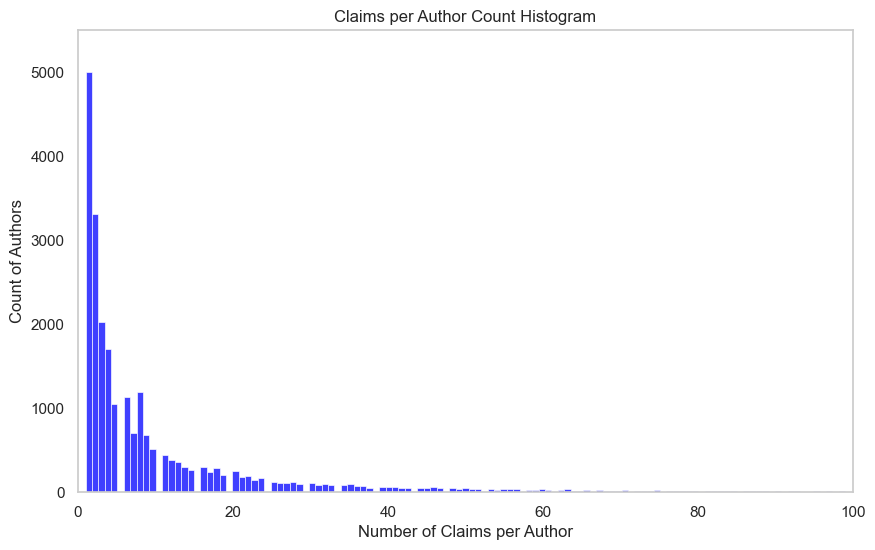

In [58]:
plot_and_save_histogram(claims_per_author,  'claims_per_author_histogram', 'Claims per Author Count Histogram', 'Number of Claims per Author', 'Count of Authors', x_max=100, y_max=5500)


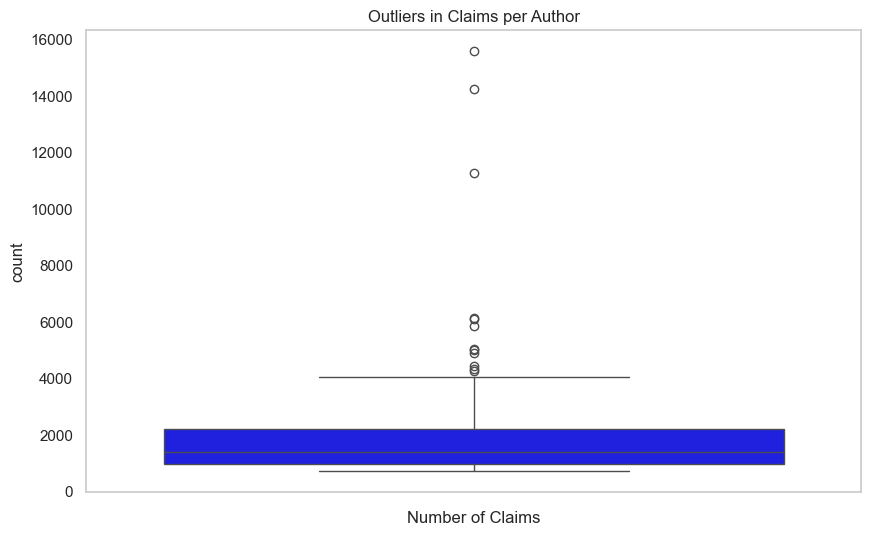

In [78]:
plot_and_save_boxplot(author_outliers, 'author_outliers', 'Outliers in Claims per Author', 'Number of Claims')

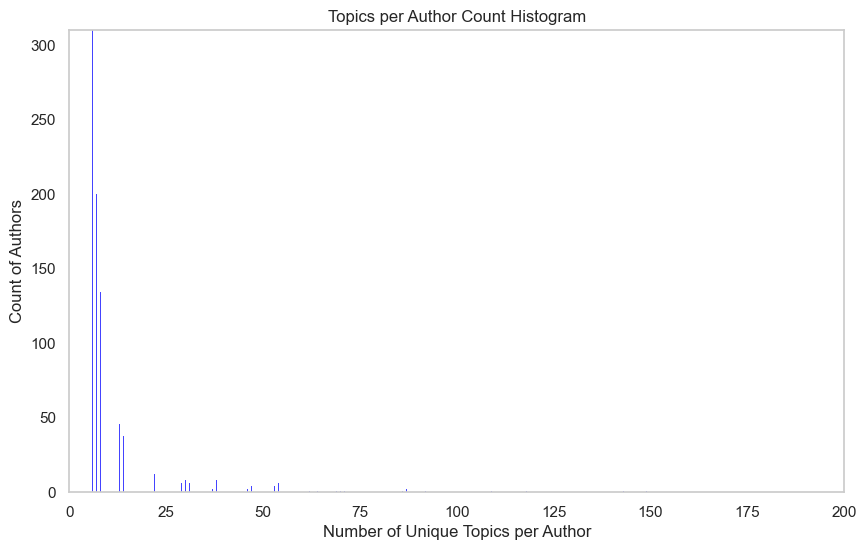

In [59]:
plot_and_save_histogram(topics_per_author,  'topics_per_author_histogram', 'Topics per Author Count Histogram', 'Number of Unique Topics per Author', 'Count of Authors', x_max=200, y_max=310)


303


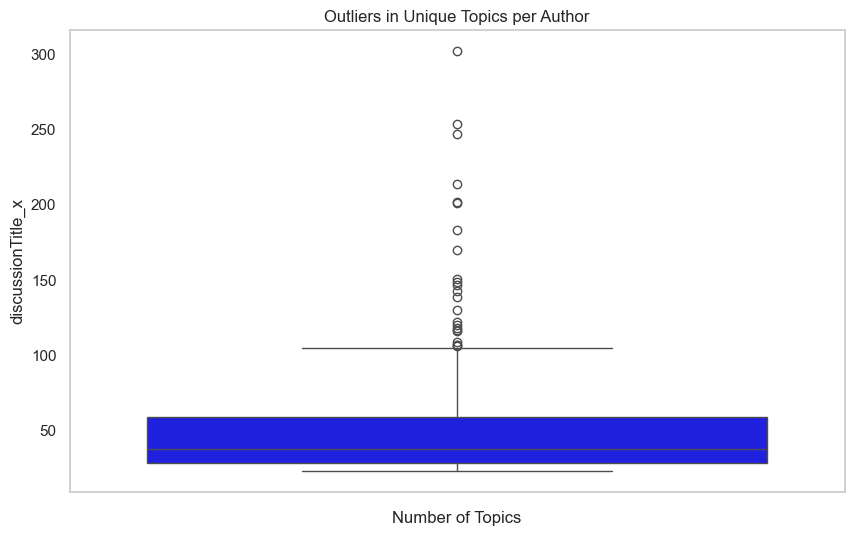

In [52]:
plot_and_save_boxplot(topics_per_author_outliers, 'topics_per_author_outliers', 'Outliers in Unique Topics per Author', 'Number of Topics')


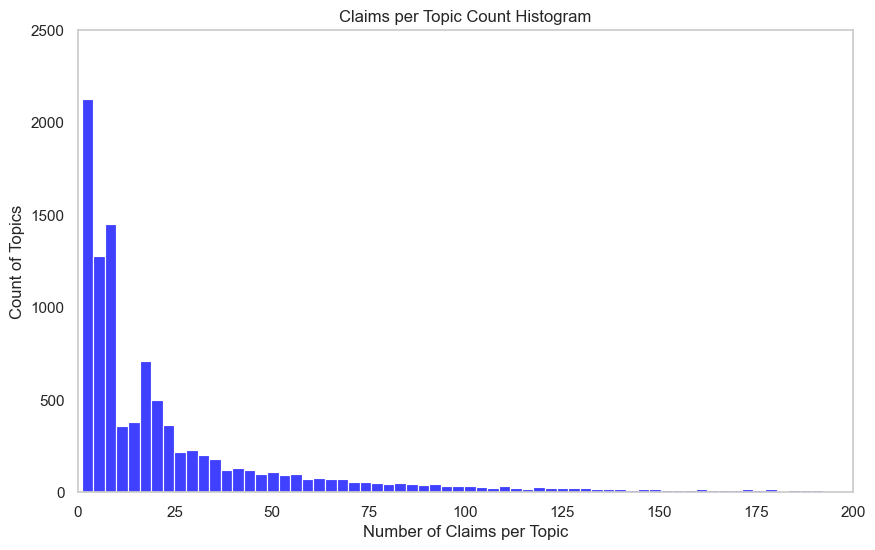

In [62]:
plot_and_save_histogram(claims_per_topic, 'claims_per_topic_histogram', 'Claims per Topic Count Histogram', 'Number of Claims per Topic', 'Count of Topics', x_max=200, y_max=2500)

9229


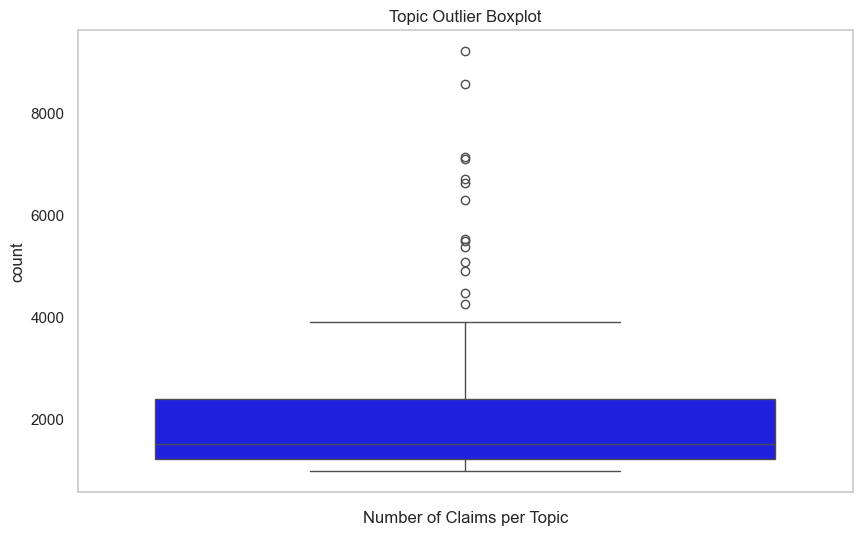

In [34]:
plot_and_save_boxplot(topic_outliers, 'topic_outliers_boxplot', 'Topic Outlier Boxplot', 'Number of Claims per Topic')


Stance Type Counts:
stanceType
-1.0    306343
 1.0    301980
Name: count, dtype: int64


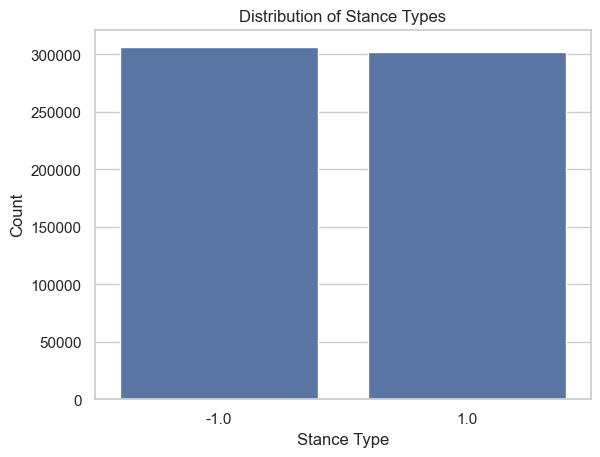

In [65]:
df_filtered = df_positions_clean[df_positions_clean['stanceType'] != 0.0]

# Calculate stance counts without 0.00 values
stance_counts = df_filtered['stanceType'].value_counts()

# Print the counts for each stance type
print("Stance Type Counts:")
print(stance_counts)

# Bar plot for Stance Type Distribution
sns.barplot(x=stance_counts.index, y=stance_counts.values).set_title('Distribution of Stance Types')
plt.xlabel("Stance Type")
plt.ylabel("Count")
plt.show()

In [67]:
# Calculating relevant metadata for claims_per_author, claims_per_topic, and topics_per_author
metadata = {
    'Total Number': [claims_per_author.sum(), claims_per_topic.sum(), topics_per_author.sum()],
    'Median': [claims_per_author.median(), claims_per_topic.median(), topics_per_author.median()],
    'Unique': [claims_per_author.nunique(), claims_per_topic.nunique(), topics_per_author.nunique()],
    'Number of Outliers': [author_outliers.size, topic_outliers.size, topics_per_author_outliers.size]
}

# Creating a summary DataFrame
summary_df = pd.DataFrame(metadata, index=['Claims per Author', 'Claims per Topic', 'Topics per Author'])

summary_df



,Total Number,Median,Unique,Number of Outliers
Claims per Author,746630,5.0,576,170
Claims per Topic,746630,14.0,650,114
Topics per Author,57471,1.0,106,238


In [68]:
total_unique_claims = df_merged['claimId'].nunique() if 'claimId' in df_merged.columns else "Not Available"
total_unique_topics = df_merged['discussionTitle_x'].nunique() if 'discussionTitle_x' in df_merged.columns else "Not Available"
total_unique_authors = df_merged['authorId'].nunique() if 'authorId' in df_merged.columns else "Not Available"

# Update the summary DataFrame with additional totals
summary_df.loc['Unique Claims'] = [total_unique_claims, None, None, None]
summary_df.loc[' Unique Topics'] = [None, total_unique_topics, None, None]
summary_df.loc['Unique Authors'] = [None, None, total_unique_authors, None]

summary_df


,Total Number,Median,Unique,Number of Outliers
Claims per Author,746630.0,5.0,576.0,170.0
Claims per Topic,746630.0,14.0,650.0,114.0
Topics per Author,57471.0,1.0,106.0,238.0
Unique Claims,225716.0,NaN,NaN,NaN
Unique Topics,NaN,10758.0,NaN,NaN
Unique Authors,NaN,NaN,24736.0,NaN


Number of unique claims per author: 24736
Total number of count: 746630
Median number of count per claims per author: 5.0
Number of outlier claims per author: 170


Number of unique claims per topic: 10758
Total number of count: 746630
Median number of count per claims per topic: 14.0
Number of outlier claims per topic: 114

Number of unique number of claims: 225716
Total number of count: 746630
Median number of count per number of claims: 2.0
Number of outlier number of claims: 3613


Number of unique topics per author: 24736
Total number of count: 57471
Median number of count per topics per author: 1.0
Number of outlier topics per author: 238


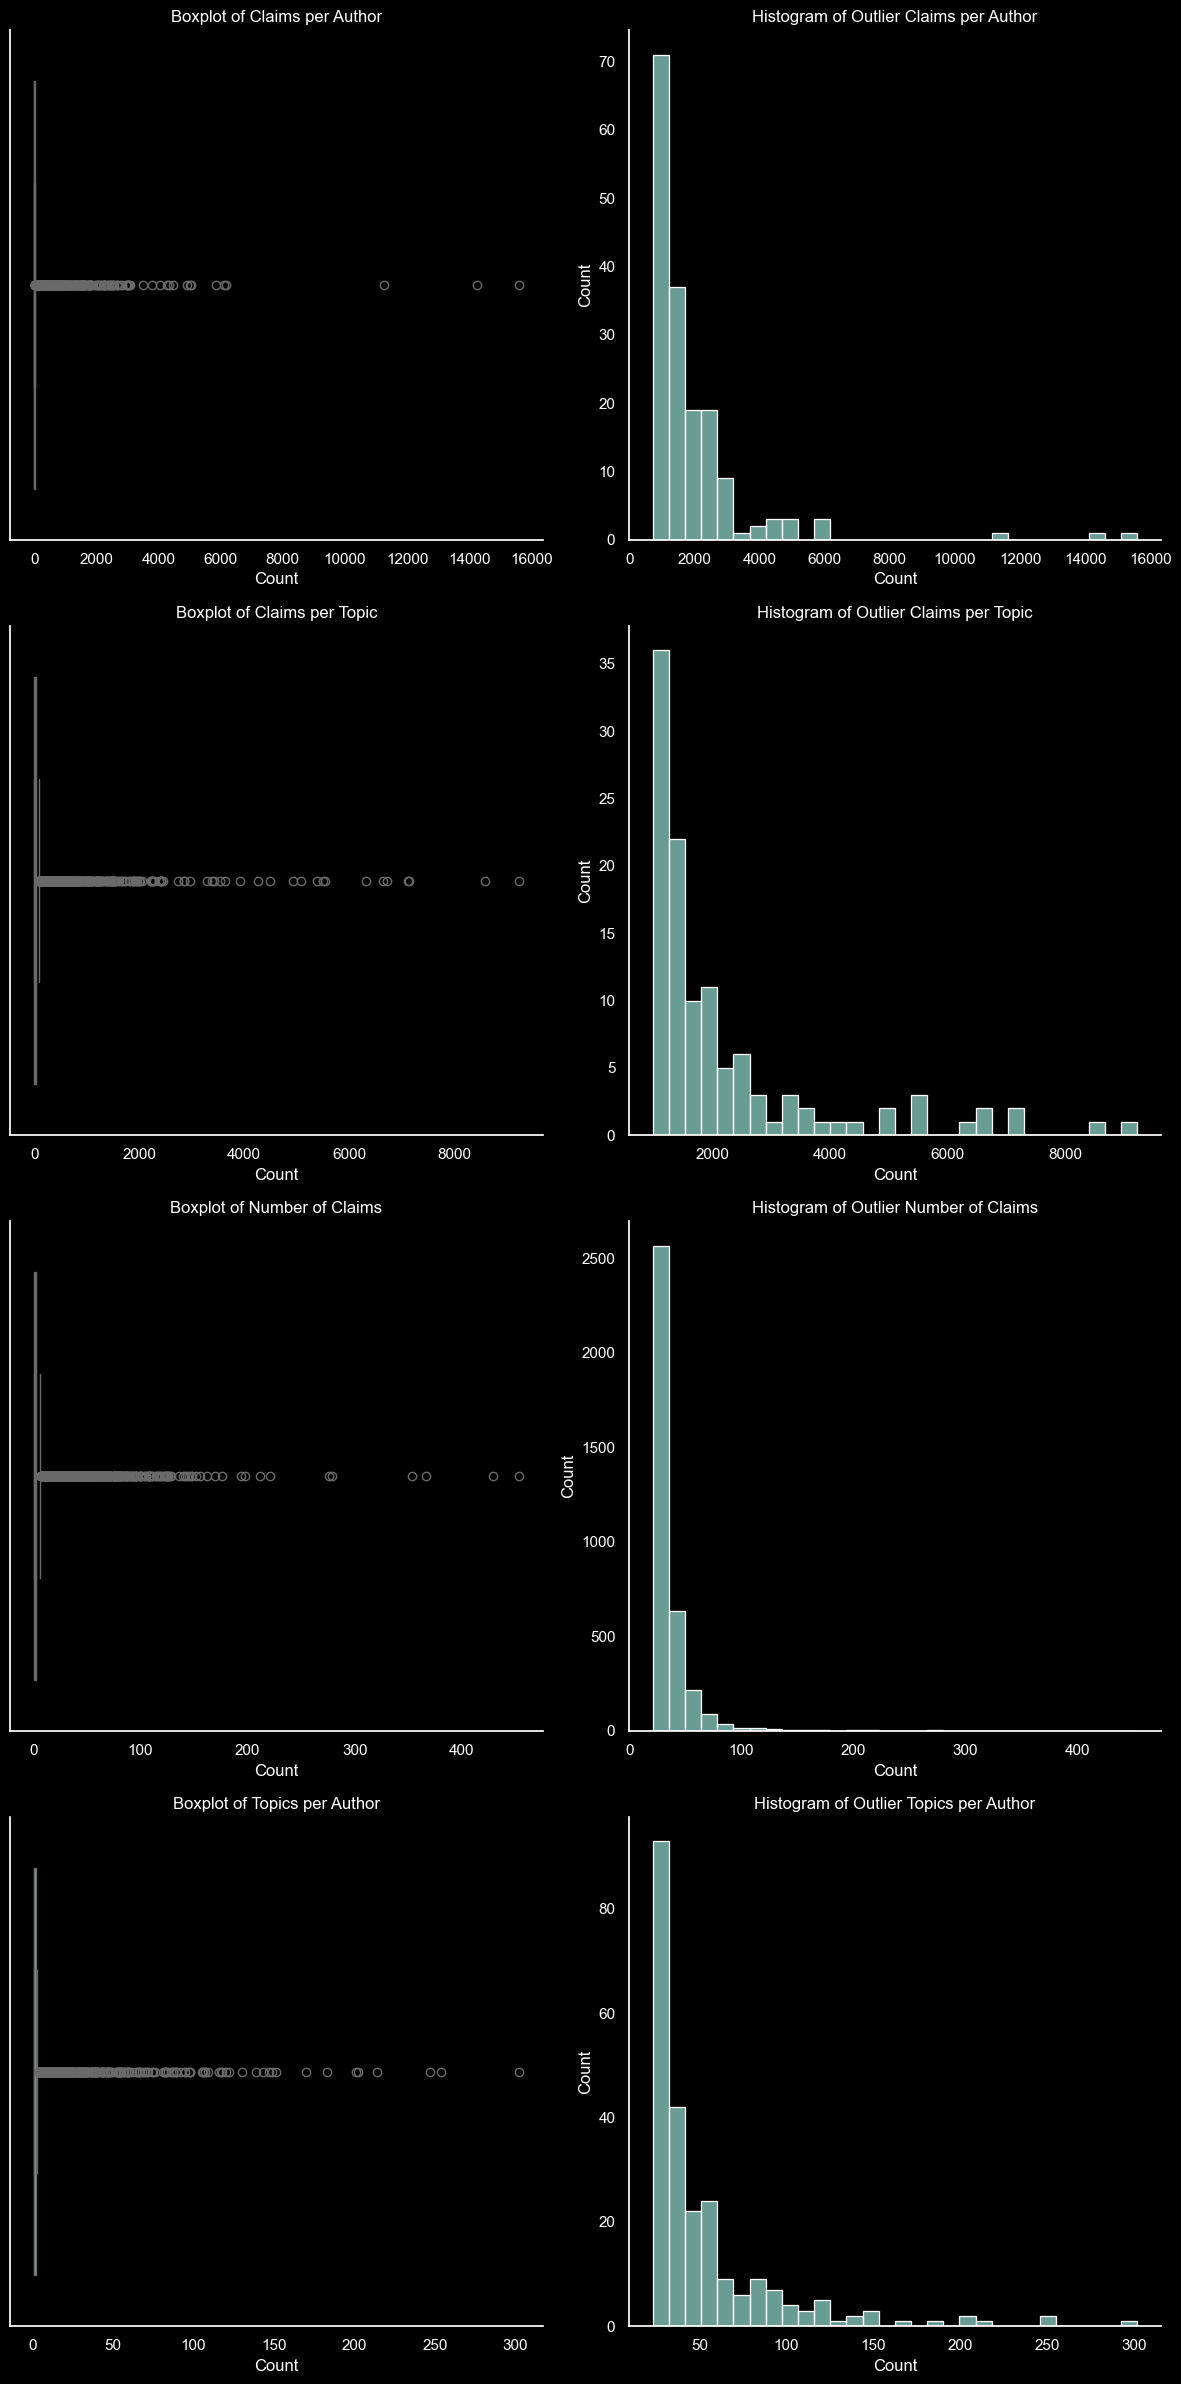

In [38]:

# Merge DataFrames
df_merged = pd.merge(df_claims_clean, df_positions_clean, left_on='claimId', right_on='targetClaimId', how='left')

# Remove missing values and duplicates
df_merged.dropna(subset=['claimId', 'authorId', 'claimText', 'stanceType'], inplace=True)
df_merged.drop_duplicates(inplace=True)

number_of_claims = df_merged['claimId'].value_counts()

def analyze_attribute(distribution, ax_box, ax_hist, title, xlabel):
    # Z-Scores for outlier detection
    z_scores = zscore(distribution)
    outliers = distribution[(z_scores > 3) | (z_scores < -3)]

    # Boxplot
    sns.boxplot(x=distribution, ax=ax_box).set_title(f'Boxplot of {title}')
    ax_box.set_xlabel(xlabel)

    # Histogram for outliers
    sns.histplot(outliers, kde=False, bins=30, ax=ax_hist).set_title(f'Histogram of Outlier {title}')
    ax_hist.set_xlabel(xlabel)

    # Print statistics
    print(f"Number of unique {title.lower()}: {distribution.size}")
    print(f"Total number of {xlabel.lower()}: {distribution.sum()}")
    print(f"Median number of {xlabel.lower()} per {title.lower()}: {distribution.median()}")
    print(f"Number of outlier {title.lower()}: {outliers.size}")
    print("\n")

# Set up matplotlib figure
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 24))

# Analyze each attribute separately
analyze_attribute(claims_per_author, axs[0, 0], axs[0, 1], 'Claims per Author', 'Count')
analyze_attribute(claims_per_topic, axs[1, 0], axs[1, 1], 'Claims per Topic', 'Count')
analyze_attribute(number_of_claims, axs[2, 0], axs[2, 1], 'Number of Claims', 'Count')
analyze_attribute(topics_per_author, axs[3, 0], axs[3, 1], 'Topics per Author', 'Count')  # Pass the actual Series here

plt.tight_layout()
plt.show()


In [29]:
# Save the plots
boxplot_path = 'data_preparation/kialo_data/4_diagram_files/boxplot_claims_per_author.png'
hist_claims_per_topic_path = 'data_preparation/kialo_data/4_diagram_files/histogram_claims_per_topic.png'
hist_depth_of_claims_path = 'data_preparation/kialo_data/4_diagram_files/histogram_depth_of_claims.png'

boxplot_path, hist_claims_per_topic_path, hist_depth_of_claims_path

('data_preparation/kialo_data/4_diagram_files/boxplot_claims_per_author.png',
 'data_preparation/kialo_data/4_diagram_files/histogram_claims_per_topic.png',
 'data_preparation/kialo_data/4_diagram_files/histogram_depth_of_claims.png')

In [24]:
fig.savefig(boxplot_path)
fig.savefig(hist_claims_per_topic_path)
fig.savefig(hist_depth_of_claims_path)


# Graph Representation

## Parsing the discussion graph

The discussion graph is parsed from the JSON structure. The graph is represented as a directed graph, where the nodes are claims and the edges are positions with a relation/stance type (Pro or Con).

Skipped data:
- the discussions with missing claims or locations since they do not provide useful information in their isolated state.
- locations that are marked as deleted or have no parent claim and thus are irrelevant.

In [ ]:
pickle_file = open(r"C:\Users\nico\Dropbox\HSLU\Bachelorarbeit\Code\data\dumped_discussions_first.pickle", "rb")
# load discussions

dumped_discussions = pickle.load(pickle_file)


# parse_graph
def parse_discussion_graph(discussion):
    # added check for missing claims or locations
    if 'claims' not in discussion['discussion'] or 'locations' not in discussion['discussion']:
        print(f"Skipping discussion due to missing 'claims' or 'locations': {discussion['title']}")
        return None  # Return None if claims or locations are missing

    discussion_graph = ig.Graph()
    vertex_id_mappings = {}

    for i, claim in enumerate(discussion["discussion"]["claims"]):
        vertex = discussion_graph.add_vertex({"id": claim["id"], "text": claim["text"]})
        vertex_id_mappings[claim["id"]] = vertex.index

    for location in discussion["discussion"]["locations"]:
        if location["isDeleted"] == True:
            continue
        if location["parentId"] is None:
            continue

        source = vertex_id_mappings[location["targetId"]]
        parent = vertex_id_mappings[location["parentId"]]
        discussion_graph.add_edge(source=source, target=parent, relation=location["relation"])

    # ignore isolated (no edge) claims
    discussion_graph.vs.select(_degree=0).delete()

    return discussion_graph


parsed_discussion_graphs = [parse_discussion_graph(dumped_discussion) for dumped_discussion in dumped_discussions if
                            dumped_discussion is not None]


In [ ]:
!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.7 MB/s eta 0:00:00


In [85]:
# Load the parsed discussion graphs from the saved pickle file

#pickle_file_path ="parsed_discussion_graphs.pickle"
pickle_file_path = r'parsed_discussion_graphs.pickle' #(LOCAL)
#pickle_file_path = r"/content/drive/MyDrive/Can Language Models Follow Discussions?/Data - kialo.com/parsed_discussion_graphs.pickle"

with open(pickle_file_path, 'rb') as f:
    parsed_discussion_graphs = pickle.load(f)

In [86]:
# Check the type and number of loaded graphs
num_of_graphs = len(parsed_discussion_graphs)
type(parsed_discussion_graphs), num_of_graphs

(list, 17832)

In [89]:
print(parsed_discussion_graphs[0])

IGRAPH UN-- 601 610 --
+ attr: name (v), relation (e)
+ edges (vertex names):
{'id': '333.1', 'text': 'An anonymous untrackable digital currency \\(ADC\\),
like Bitcoin, is beneficial for civilized societies.'}--{'id': '333.2',
'text': "Cash is a necessary part of any functional society's economic model
and cryptocurrencies are an easier and online-ready form of cash. They are the
natural progression of what money is becoming in the digital age."}, {'id':
'333.1', 'text': 'An anonymous untrackable digital currency \\(ADC\\), like
Bitcoin, is beneficial for civilized societies.'}--{'id': '333.3', 'text':
'Most ordinary citizens would not use such a currency anyway, rendering all
potential benefits moot.'}, {'id': '333.3', 'text': 'Most ordinary citizens
would not use such a currency anyway, rendering all potential benefits
moot.'}--{'id': '333.7', 'text': 'If people really wanted anonymity, they
would use more cash and make less use of credit and debit cards.'}, {'id':
'333.1', 'text': 

## ID Structure

**Theme ID**: First set of numbers before the period, e.g., 801 in 801.210.  
**Claim ID**: Numbers after the period, e.g., 210 in 801.210.

***Inconsistent Incrementation Logic***  
**+0.1**: New main point or counter-point to the theme.    
**+0.01**: Sub-point or counter-point to a main point.  
**+0.001**: ...  
2 consecutive Ids do not mean chornological order (TODO: reason?)   

The ***Titles/Themes*** are at the X.1 location and not at the X.0 location!


---


*X.0 location have to be investigated if they add anything more but noise, it seems like the .0-location is just a filler line and can be removed (TODO).

## Methods Used for Analyzing Graph Structures

---



### 1. Depth and Breadth (Scope: Entire Discussion)
- **Depth**: Measured in integer levels (0, 1, 2, ...). A depth greater than 3 indicates a multi-layered discussion, while a depth of 2 or less suggests a less complex discussion.
- **Breadth**: Measured in integer counts of viewpoints at each level. A breadth greater than 5 implies a diverse discussion, while a breadth of 2 or less indicates a narrow range of viewpoints.

### 2. Centrality Measures (Scope: Individual Claims)
- **Degree Centrality**: Ranges from 0 to N-1, where N is the number of nodes in the graph. A degree centrality greater than N/2 indicates a well-connected node, while a value less than N/4 suggests lesser connectivity.
- **Closeness Centrality**: Ranges from 0 to 1. A closeness centrality greater than 0.6 indicates nodes that are more central, while a value less than 0.4 suggests peripheral nodes.
- **Betweenness Centrality**: Ranges from 0 to (N-1)(N-2)/2. A betweenness centrality greater than N^2/4 indicates nodes that serve as key "bridges," while a value less than N^2/8 suggests otherwise.

### 3. Communities (Scope: Groups of Claims)
- **Community Connectivity**: Calculated as the ratio of inter-community edges to the total number of communities. A value less than 0.2 indicates more isolated communities, while a value greater than 0.5 suggests less isolated ones.

## Discussion Structure: Depth and Breadth Analysis

- *Depth*: Maximum number of levels in each discussion.
- *Breadth*: Average number of child nodes per parent node.

In [ ]:
none_count = sum([1 for graph in parsed_discussion_graphs if graph is None])
empty_count = 0

depths = []
breadths = []

for graph in parsed_discussion_graphs:
    if graph is None:   
        print("Skipping None graph.")
        continue

    if len(graph.vs) == 0:
        print("Skipping empty graph.")
        empty_count += 1
        continue

    # Depth: Longest path in the graph
    distances = np.array(graph.distances())
    depth = np.max(distances[distances < np.inf])  # Exclude infinite values
    depths.append(depth)

    # Breadth: Average number of child nodes per parent
    avg_degree = np.mean(graph.degree(mode="out"))
    breadths.append(avg_degree)



In [91]:
print(f"Number of None-graphs: {none_count}")
print(f"Number of Empty-graphs: {empty_count}")

Number of None-graphs: 2
Number of Empty-graphs: 849


In [100]:
mean_depth = np.mean(depths)
median_depth = np.median(depths)
std_dev_depth = np.std(depths)
print("depth mean: ", mean_depth)
print("depth median: ", median_depth)
print("std dev depth: ", std_dev_depth)
print("\n")
mean_breadth = np.mean(breadths)
median_breadth = np.median(breadths)
std_dev_breadth = np.std(breadths)
print("mean_breadth: ", mean_breadth)
print("median_breadth: ", median_breadth)
print("std_dev_breadth: ", std_dev_breadth)


depth mean:  3.4818326364760614
depth median:  2.0
std dev depth:  3.6829125176557675


mean_breadth:  1.5272547237333767
median_breadth:  1.7142857142857142
std_dev_breadth:  0.4125034907430631


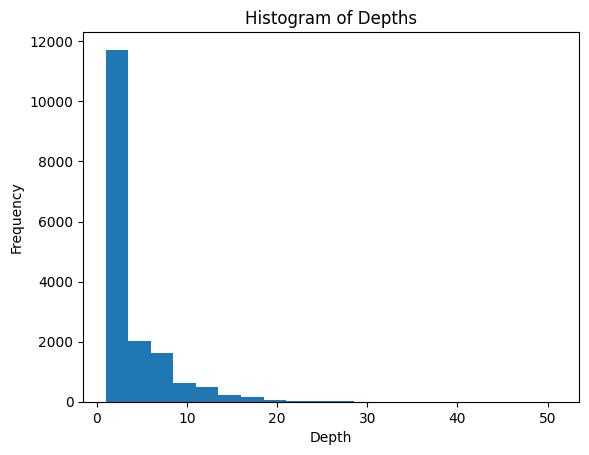

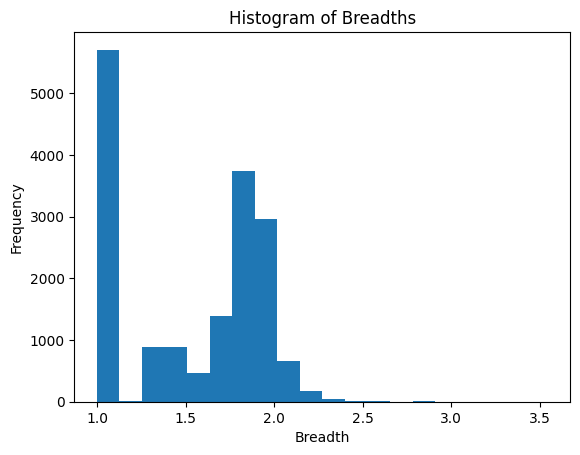

In [ ]:
import matplotlib.pyplot as plt

plt.hist(depths, bins=20)
plt.title('Histogram of Depths')
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.show()

plt.hist(breadths, bins=20)
plt.title('Histogram of Breadths')
plt.xlabel('Breadth')
plt.ylabel('Frequency')
plt.show()


### Discussion Structure Report

#### Objective
The aim of this section is to understand the depth and breadth of discussions in the dataset and their implications for assessing the ability of language models to follow discussions.

#### Methodology
**What It Measures:** Depth gauges the "length" of the discussion threads. In a graph, this corresponds to the longest path from the central node (base claim) to any leaf node (end point) in a given theme or discussion.

**Unit:** Number of edges along the longest path in the discussion.

**Interpretation:** A higher depth suggests that the discussion has multiple layers of reasoning, with arguments being countered or supported by subsequent arguments.

**Example:** If a base claim has a counter-argument, which itself has another counter-argument, and so on, the discussion is deep.

#### Breadth
**What It Measures:** Breadth evaluates the "width" of the discussions. In graph terms, this translates to the average number of child nodes that each parent node has in the discussion.

**Unit:** Average number of child nodes per parent node.

**Interpretation:** A greater breadth means more diversity in viewpoints or arguments at the same level in the discussion.

**Example:** If a base claim has multiple, different diverse arguments at the same level, that are not necessarily clearly wright or wrong / clearly debatable. The discussion is broad.

#### Key Difference
Depth focuses on the linear extent of discussions, measuring how "deep" a single thread of reasoning can go. Breadth, on the other hand, focuses on the spread of discussions at each level, capturing how many different viewpoints or arguments are presented.

#### Findings

##### Depth of Discussions
- Mean: 3.48 claims deep
- Median: 2.0 claims deep
- Standard Deviation: 3.68 claims deep

#### Breadth of Discussions
- Mean: 1.53 child nodes
- Median: 1.71 child nodes
- Standard Deviation: 0.41 child nodes

##### Correlation Between Depth and Breadth
- Value: 0.66

#### Interpretation

##### Depth
- **Shallow Depth**: The shallow depth in most discussions suggests that arguments are usually not extensively countered or supported, implying straightforward discussions.

##### Breadth
- **Narrow Breadth**: Indicates less diversity in viewpoints at the same argument level. However discussion can still be deep and informative.
- **Wide Breadth**: Implies more diversity but could also mean redundancy or lack of full engagement from participants.
##### Correlation
A correlation of approximately 0.66 between depth and breadth suggests a moderate positive correlation. This could imply that discussions that are deeper (more complex) also tend to have more branches (breadth) or the other way round.
#### Conclusions
- **Depth**: Most discussions are straightforward and don't delve deep into additional layers of reasoning.
- **Breadth**: There is a varied breadth, indicating that while some discussions may lack diversity, others offer a range of viewpoints.
#### What does that implicate for the understanding of language model?
- **Correlation** + **Shallow Depth**: Language models need to be able to ***follow both shallow and deep discussions***. The shallow depth of most discussions suggests that language models need to be able to understand and respond to straightforward arguments. However, the moderate positive correlation between depth and breadth suggests that language models should also be able to follow more complex discussions that involve multiple layers of reasoning and diverse viewpoints.
- **Narrow Breadth**: Language models need to be able to ***identify and respond to the most important arguments in a discussion***. The narrow breadth of many discussions suggests that language models should be able to identify and respond to the most important arguments in a discussion, even if there are other, less important arguments being made.
- **Wide Breadth**: Language models need to be able to ***avoid redundancy and repetitive arguments***. The wide breadth of some discussions suggests that language models should be able to avoid redundancy and repetitive arguments. Language models should be able to identify and summarize the main arguments in a discussion, and avoid repeating arguments that have already been made.

## Centrality Measures

In [101]:
# Empty lists for storing graph metrics are initialized.
communities_list = []
degree_centrality_list = []
closeness_centrality_list = []
betweenness_centrality_list = []

# Metrics for each graph in the parsed discussions are calculated.
for graph in parsed_discussion_graphs:
   if graph is not None:
    # Community Detection
    community = graph.community_multilevel()
    communities_list.append(community)

    # Degree Centrality
    degree_centrality = graph.degree()  # A list of degree centralities for each node is obtained.
    degree_centrality_list.append(np.mean(degree_centrality))  # The average degree centrality is stored.

    # Closeness Centrality
    closeness_centrality = graph.closeness()  # A list of closeness centralities for each node is obtained.
    closeness_centrality_list.append(np.mean(closeness_centrality))  # The average closeness centrality is stored.

    # Betweenness Centrality
    betweenness_centrality = graph.betweenness()  # A list of betweenness centralities for each node is obtained.
    betweenness_centrality_list.append(np.mean(betweenness_centrality))  # The average betweenness centrality is stored.

# Lists are converted to NumPy arrays for easier analysis.
degree_centrality_array = np.array(degree_centrality_list)
closeness_centrality_array = np.array(closeness_centrality_list)
betweenness_centrality_array = np.array(betweenness_centrality_list)


C:\Users\nico\.virtualenvs\Dropbox\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nico\.virtualenvs\Dropbox\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [102]:
print(len(degree_centrality_array),len(closeness_centrality_array),len(betweenness_centrality_array))

17830 17830 17830


In [ ]:
print(degree_centrality_array,closeness_centrality_array,betweenness_centrality_array)

[2.02995008 2.00607903 2.07203962 ... 1.66666667 1.         1.        ] [0.30582876 0.20925638 0.2443798  ... 0.62962963 1.         1.        ] [7.96720466e+02 6.77835866e+02 4.08559208e+03 ... 1.66666667e+00
 0.00000000e+00 0.00000000e+00]


In [110]:
# Check for nan values in each array
degree_has_nan = np.isnan(degree_centrality_array).any()
closeness_has_nan = np.isnan(closeness_centrality_array).any()
betweenness_has_nan = np.isnan(betweenness_centrality_array).any()

# Handle nan values
if degree_has_nan:
    degree_centrality_array = degree_centrality_array[~np.isnan(degree_centrality_array)]
if closeness_has_nan:
    closeness_centrality_array = closeness_centrality_array[~np.isnan(closeness_centrality_array)]
if betweenness_has_nan:
    betweenness_centrality_array = betweenness_centrality_array[~np.isnan(betweenness_centrality_array)]

# Calculate the mean
degree_centrality_mean = np.mean(degree_centrality_array)
closeness_centrality_mean = np.mean(closeness_centrality_array)
betweenness_centrality_mean = np.mean(betweenness_centrality_array)

print(degree_centrality_mean, closeness_centrality_mean, betweenness_centrality_mean)


1.5272547237333767 0.6587293012546684 70.47713654619109


In [111]:
degree_centrality_median = np.median(degree_centrality_array)
closeness_centrality_median= np.median(closeness_centrality_array)
betweenness_centrality_median = np.median(betweenness_centrality_array)
print(degree_centrality_median, closeness_centrality_median, betweenness_centrality_median)

1.7142857142857142 0.596153846153846 2.142857142857143


Summary Statistics
                   Metric    Median
0       Degree Centrality  1.714286
1    Closeness Centrality  0.596154
2  Betweenness Centrality  2.142857


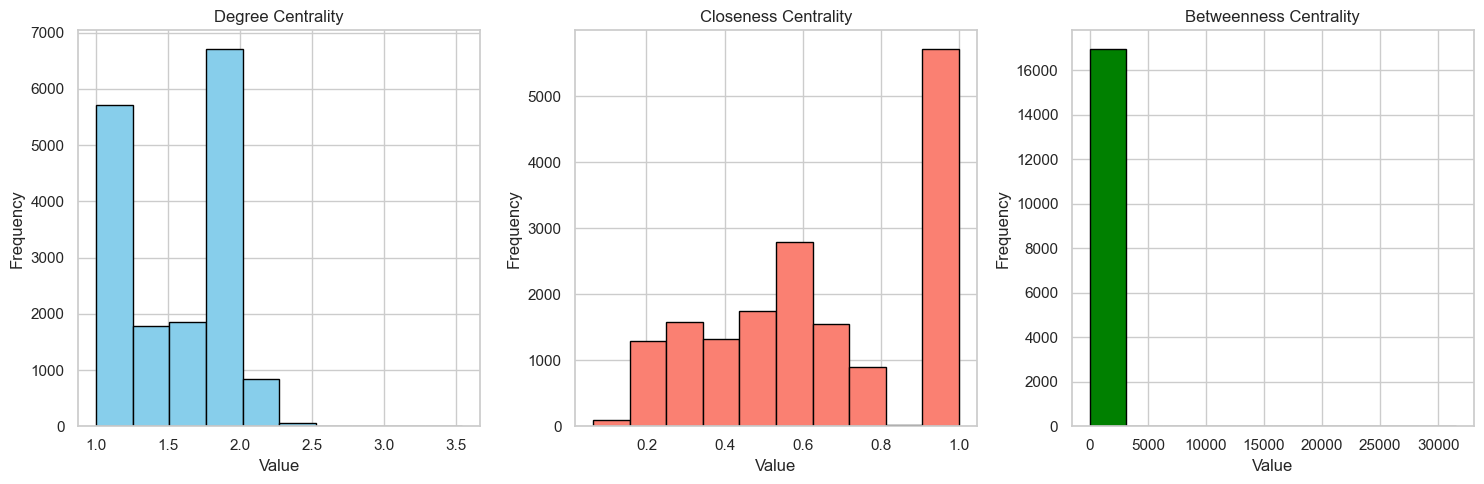

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality'],
    'Median': [degree_centrality_median, closeness_centrality_median, betweenness_centrality_median]
})

# Display summary statistics as a table
print("Summary Statistics")
print(summary_stats)

# Plot histograms for Degree, Closeness, and Betweenness Centrality
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Degree Centrality
axes[0].hist(degree_centrality_array, bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Degree Centrality')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Closeness Centrality
axes[1].hist(closeness_centrality_array, bins=10, color='salmon', edgecolor='black')
axes[1].set_title('Closeness Centrality')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Betweenness Centrality
axes[2].hist(betweenness_centrality_array, bins=10, color='green', edgecolor='black')
axes[2].set_title('Betweenness Centrality')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')

# Show plots
plt.tight_layout()
plt.show()


In [113]:
print(np.var(degree_centrality_array),np.var(closeness_centrality_array),np.var(betweenness_centrality_array)  )

0.1701591298752123 0.07908620111243236 293315.4410856919


In [116]:
# Given values from the histograms and summary statistics for a network with 17830 nodes.
N = 17830
#degree_centrality_median = 1.714286
#closeness_centrality_median = 0.596154
#betweenness_centrality_median = 2.142857

# Applying the given rules for centrality measures
# For Degree Centrality
well_connected_threshold = 2/N
lesser_connectivity_threshold = N/4

# For Closeness Centrality
more_central_threshold = 0.6
peripheral_threshold = 0.4

# For Betweenness Centrality
key_bridges_threshold = (N-1)*(N-2)/4
less_central_threshold = (N-1)*(N-2)/8

# Calculate the actual thresholds
degree_well_connected = well_connected_threshold
degree_lesser_connected = lesser_connectivity_threshold
closeness_more_central = more_central_threshold
closeness_peripheral = peripheral_threshold
betweenness_key_bridges = key_bridges_threshold
betweenness_less_central = less_central_threshold

# Interpretation based on median values from the histograms and the calculated thresholds
degree_interpretation = ("Degree C: Well connected" if degree_centrality_median > degree_well_connected
                         else "Degree C: Lesser connectivity")

closeness_interpretation = ("Closeness C: More central" if closeness_centrality_median > closeness_more_central
                            else "Closeness C: Peripheral")

betweenness_interpretation = ("Betweenness C: Key bridges" if betweenness_centrality_median > betweenness_key_bridges
                              else "Betweenness C: Less central")

degree_interpretation, closeness_interpretation, betweenness_interpretation, degree_well_connected, degree_lesser_connected, betweenness_key_bridges, betweenness_less_central



('Degree C: Well connected',
 'Closeness C: Peripheral',
 'Betweenness C: Less central',
 0.00011217049915872125,
 4457.5,
 79463853.0,
 39731926.5)

### Interpretation of Histograms and Congruency with Previous Findings

#### Degree Centrality
Low values (~1) indicate that many base claims or arguments are not highly connected, possibly because they are standalone points or are not heavily debated. A peak before the middle indicates a set of arguments that are well-connected but not central to the theme. These could be supporting or subsidiary claims.

This aligns with the breadth of discussions, where the mean is around 1.53, indicating a narrow range of viewpoints at each argument level. Nodes with lower degree centrality indicate fewer connections, which is consistent with a narrow breadth in discussions.

#### Closeness Centrality
A high frequency at the end (~1) suggests that many nodes are closely related to each other within their respective themes. This could indicate that discussions on the platform are usually concentrated around a few key points or themes.

This moderate correlation can be related to the depth of discussions. The higher frequency at the end of the Closeness Centrality histogram suggests that many claims are closely related to their parent/base claims, possibly leading to more breadth when there is more depth.

#### Betweenness Centrality
A high number (160000) at the beginning (~ 0-2500, weak score) shows that most arguments don't serve as bridges between other arguments. This aligns with the idea that each theme is independent; hence there are fewer 'bridge' arguments connecting different themes or points.

This is consistent with the depth of discussions, where your data showed that most discussions are not very deep, usually around 3-4 claims. Lower betweenness centrality indicates that most claims are not serving as bridges for deeper-level discussions.

#### Implications for Understanding Language Models
The correlation between depth and breadth, along with the shallow depth and narrow breadth of discussions, suggests that language models should be capable of following both straightforward and complex discussions. Given the degree centrality and closeness centrality metrics, language models should also be prepared for discussions that have a wider range of viewpoints and are more complex.

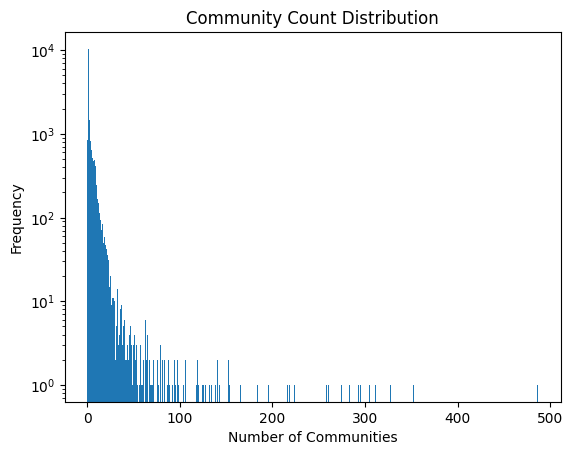

In [ ]:
import matplotlib.pyplot as plt

community_counts = [len(c) for c in communities_list]
plt.hist(community_counts, bins=range(min(community_counts), max(community_counts) + 1))
plt.title("Community Count Distribution")
plt.xlabel("Number of Communities")
plt.yscale('log') # log scale for better visualization
plt.ylabel("Frequency")
plt.show()


In [ ]:
max(community_counts)

487

TODO: DATA PROCESSING:  vertex IDs consistently removed / filtered?

In [ ]:
community_connectivity = []
for graph, community_clustering in zip(parsed_discussion_graphs, communities_list):
    if graph is not None and len(community_clustering) > 0:
        inter_edges = 0
        for cluster in community_clustering:
            for vertex in cluster:
                if vertex < graph.vcount():  # Check if vertex exists in the graph
                    for neighbor in graph.neighbors(vertex):
                        if neighbor not in cluster:
                            inter_edges += 1
        community_connectivity.append(inter_edges / len(community_clustering) if len(community_clustering) > 0 else 0)


In [ ]:
len(community_connectivity)

16979

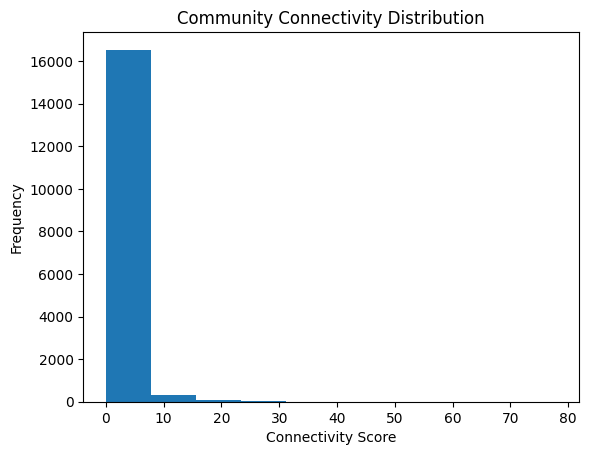

In [ ]:
plt.hist(community_connectivity, bins=10)
plt.title("Community Connectivity Distribution")
plt.xlabel("Connectivity Score")
plt.ylabel("Frequency")
plt.show()

### Outlier Detection

## Using IQR

In [ ]:
# Function to identify outliers based on IQR
def identify_outliers(data, threshold=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR * threshold)
    upper_bound = Q3 + (IQR * threshold)
    return np.where((data < lower_bound) | (data > upper_bound))[0]

# Using the function to find outlier indices
depth_outliers_indices = identify_outliers(np.array(depths))
breadth_outliers_indices = identify_outliers(np.array(breadths))

# Extracting outlier values using NumPy array indexing
depth_outliers_values = np.array(depths)[depth_outliers_indices]
breadth_outliers_values = np.array(breadths)[breadth_outliers_indices]

# ... (Your plotting code remains the same)

# Calculating and printing summary statistics of outliers
depth_outliers_mean = np.mean(depth_outliers_values)
depth_outliers_median = np.median(depth_outliers_values)
breadth_outliers_mean = np.mean(breadth_outliers_values)
breadth_outliers_median = np.median(breadth_outliers_values)

print("Depth Outliers - Mean:", depth_outliers_mean, "Median:", depth_outliers_median)
print("Breadth Outliers - Mean:", breadth_outliers_mean, "Median:", breadth_outliers_median)


Depth Outliers - Mean: 12.647904940587868 Median: 12.0
Breadth Outliers - Mean: 3.5454545454545454 Median: 3.5454545454545454


In [ ]:
print(depth_outliers_values, len(depth_outliers_values))
print()
print(breadth_outliers_values, len(breadth_outliers_values))

[15. 18. 20. ...  9. 12. 12.] 1599

[3.54545455] 1


In [ ]:
print("number of depth outliers", len(depth_outliers_values))
print("number of breadth outliers", len(breadth_outliers_values))

number of depth outliers 1599
number of breadth outliers 1


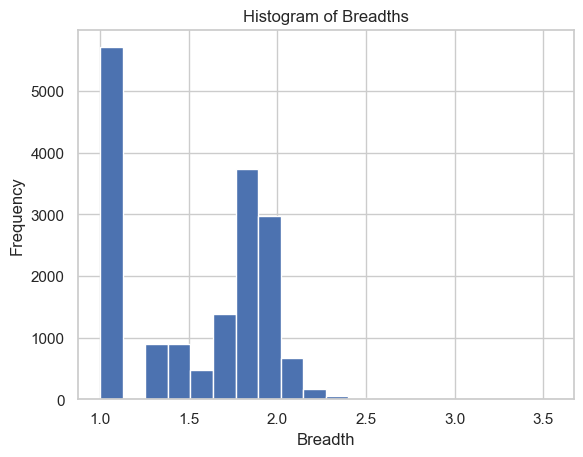

In [96]:
plt.hist(breadths, bins=20)
plt.title('Histogram of Breadths')
plt.xlabel('Breadth')
plt.ylabel('Frequency')
plt.show()


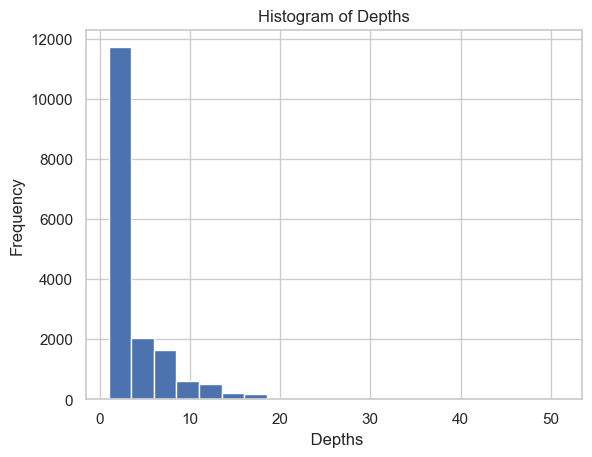

In [97]:
plt.hist(depths, bins=20)
plt.title('Histogram of Depths')
plt.xlabel(' Depths')
plt.ylabel('Frequency')
plt.show()


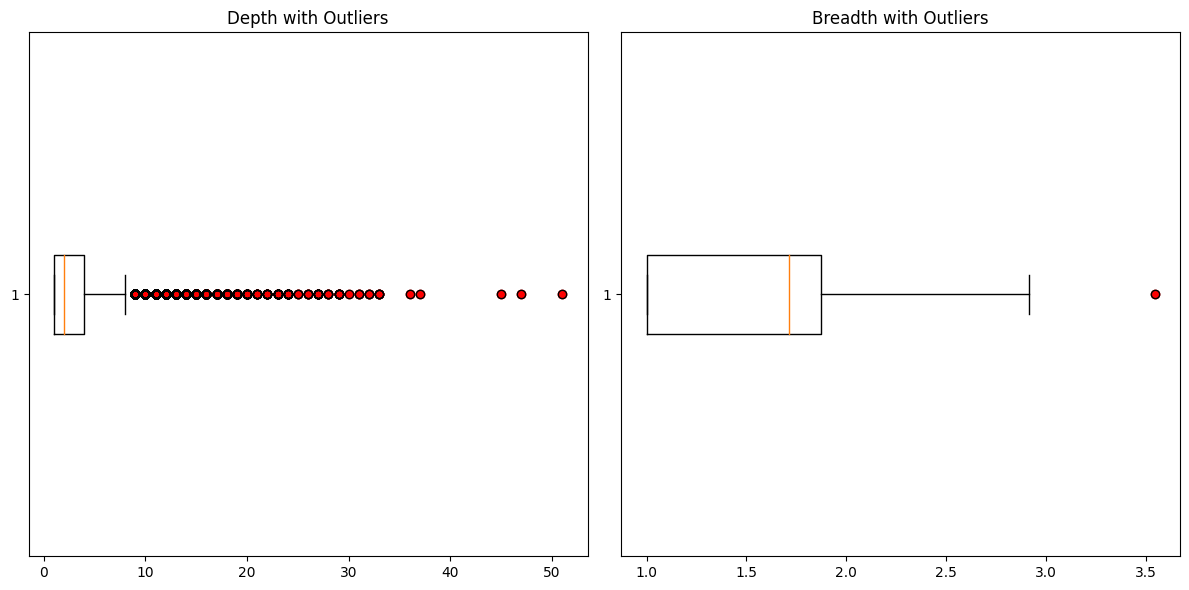

In [ ]:
# Plotting depth and breadth with outliers marked (red point)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Depth with Outliers')
plt.boxplot(depths, vert=False)
plt.scatter(depth_outliers_values, [1] * len(depth_outliers_values), color='red')

plt.subplot(1, 2, 2)
plt.title('Breadth with Outliers')
plt.boxplot(breadths, vert=False)
plt.scatter(breadth_outliers_values, [1] * len(breadth_outliers_values), color='red')

plt.tight_layout()
plt.show()


## Using z-score

Further investigating outliers by Z-Score since there was only 1 outlier detected for breadth by using IQR

In [92]:
# Function to identify outliers based on Z-score (default threshold = 3 std dev away from the mean)
def identify_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(y - mean) / std for y in data]
    return np.where(np.abs(z_scores) > threshold)[0]

# Identify outliers using Z-score method
depth_outliers_indices_z = identify_outliers_zscore(depths)
breadth_outliers_indices_z = identify_outliers_zscore(breadths)

# Extracting the values of the outliers
depth_outliers_values_z = np.array([depths[i] for i in depth_outliers_indices_z])
breadth_outliers_values_z = np.array([breadths[i] for i in breadth_outliers_indices_z])

# Number of outliers found
print("Number of depth outliers:", len(depth_outliers_values_z))
print("Number of breadth outliers:", len(breadth_outliers_values_z))


Number of depth outliers: 367
Number of breadth outliers: 7


In [93]:
depth_outliers_mean_z = np.mean(depth_outliers_values_z)
depth_outliers_median_z = np.median(depth_outliers_values_z)
breadth_outliers_mean_z = np.mean(breadth_outliers_values_z)
breadth_outliers_median_z = np.median(breadth_outliers_values_z)

print("Depth Outliers - Mean:", depth_outliers_mean_z, "Median:", depth_outliers_median_z)
print("Breadth Outliers - Mean:", breadth_outliers_mean_z, "Median:", breadth_outliers_median_z)


Depth Outliers - Mean: 18.539509536784742 Median: 17.0
Breadth Outliers - Mean: 2.937285832746659 Median: 2.8011653313911142


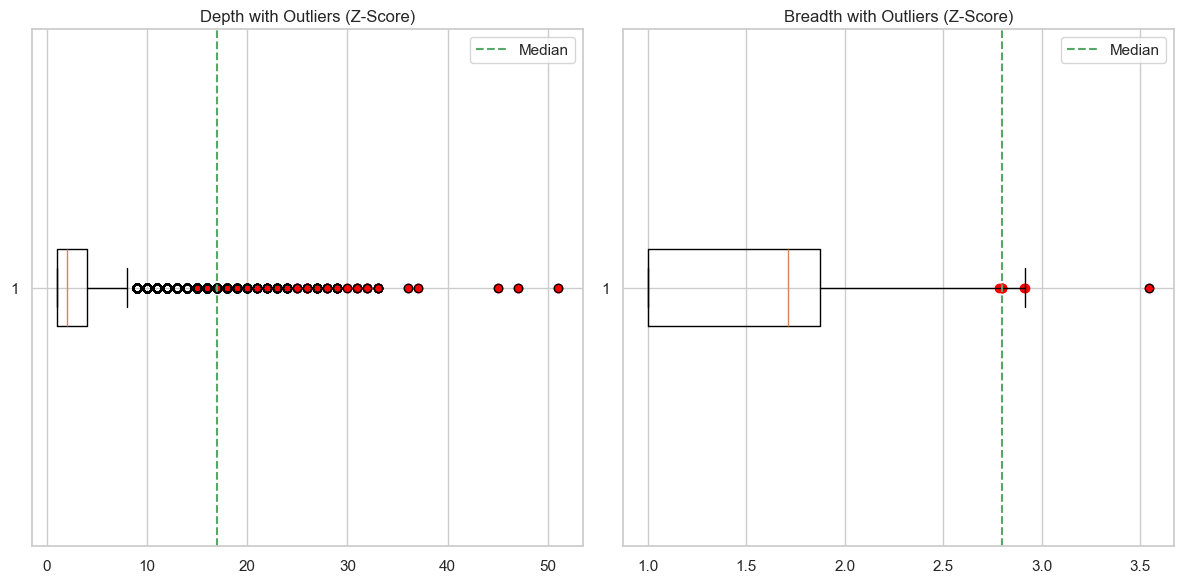

Depth Outliers - Mean: 18.539509536784742 Median: 17.0
Breadth Outliers - Mean: 2.937285832746659 Median: 2.8011653313911142


In [99]:

# Function to identify outliers based on Z-score
def identify_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(y - mean) / std for y in data]
    return np.where(np.abs(z_scores) > threshold)[0]

# Identify outliers
depth_outliers_indices_z = identify_outliers_zscore(depths)
breadth_outliers_indices_z = identify_outliers_zscore(breadths)

# Extract outlier values
depth_outliers_values_z = np.array([depths[i] for i in depth_outliers_indices_z])
breadth_outliers_values_z = np.array([breadths[i] for i in breadth_outliers_indices_z])

# Statistics for outliers
depth_outliers_mean_z = np.mean(depth_outliers_values_z)
depth_outliers_median_z = np.median(depth_outliers_values_z)

breadth_outliers_mean_z = np.mean(breadth_outliers_values_z)
breadth_outliers_median_z = np.median(breadth_outliers_values_z)
# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Depth with Outliers (Z-Score)')
plt.boxplot(depths, vert=False)
plt.scatter(depth_outliers_values_z, [1]*len(depth_outliers_values_z), color='red')
plt.axvline(x=depth_outliers_median_z, color='g', linestyle='--', label='Median')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Breadth with Outliers (Z-Score)')
plt.boxplot(breadths, vert=False)
plt.scatter(breadth_outliers_values_z, [1]*len(breadth_outliers_values_z), color='red')
plt.axvline(x=breadth_outliers_median_z, color='g', linestyle='--', label='Median')
plt.legend()

plt.tight_layout()
plt.show()


print("Depth Outliers - Mean:", depth_outliers_mean_z, "Median:", depth_outliers_median_z)
print("Breadth Outliers - Mean:", breadth_outliers_mean_z, "Median:", breadth_outliers_median_z)


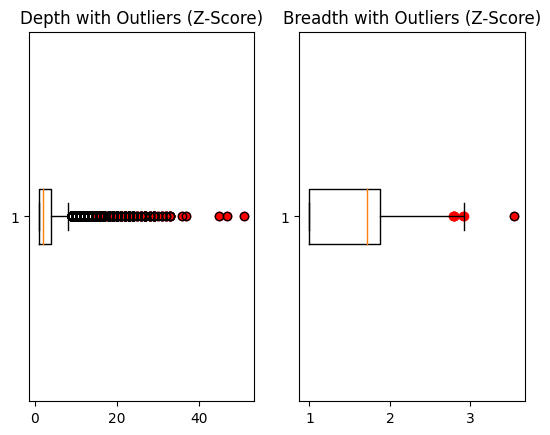

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Depth with Outliers (Z-Score)')
plt.boxplot(depths, vert=False)
plt.scatter(depth_outliers_values_z, [1] * len(depth_outliers_values_z), color='red')

plt.subplot(1, 2, 2)
plt.title('Breadth with Outliers (Z-Score)')
plt.boxplot(breadths, vert=False)
plt.scatter(breadth_outliers_values_z, [1] * len(breadth_outliers_values_z), color='red')


### Findings

#### Depth
- **Mean**: 15.0
- **Median**: 15.0

#### Breadth
- **Mean**: 2.42
- **Median**: 2.42

Given that the Z-score threshold was set to 2, the calculated mean and median suggest that discussions with a depth or breadth significantly different from these values are outliers. This could imply:

### Interpretation

#### For Depth
- Discussions with depth significantly higher than 15 ***could be highly nuanced***, with multiple layers of arguments and counterarguments.
- Conversely, discussions with a much lower depth are ***likely to be shallower/less debated***, with fewer layers of counterarguments.

#### For Breadth
- Discussions with a breadth significantly higher than 2.42 could indicate a ***wide range of perspectives*** and might be more diverse.
- Lower breadth values suggest less diversity in the arguments and may consist of ***similar points being reiterated***.

These outliers can be further analyzed to understand what makes them deviate from the norm (see below, heading = "Investigating Outliers"). The deviation could be due to the topic, the participants, or some other external factors influencing the discussion dynamics.  

In [ ]:
print(type(depth_outliers_values))
print(len(depth_outliers_values))
print(depth_outliers_values.shape)

print(type(breadth_outliers_values))
print(len(breadth_outliers_values))
print(breadth_outliers_values.shape)


<class 'numpy.ndarray'>
1
(1,)
<class 'numpy.ndarray'>
1
(1,)


In [ ]:
correlation = np.corrcoef(depths, breadths)[0, 1]
print(f"Correlation between Depth and Breadth: {correlation}")

Correlation between Depth and Breadth: 0.6595607271226105


## Graph Visualizations and Interpretations

In [ ]:
!pip install cairocffi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
parsed_discussion_graphs[0].get_edgelist()

[(1, 2),
 (1, 3),
 (3, 6),
 (1, 10),
 (1, 14),
 (14, 15),
 (14, 16),
 (14, 17),
 (15, 18),
 (16, 19),
 (20, 21),
 (17, 22),
 (25, 26),
 (1, 29),
 (3, 31),
 (31, 32),
 (34, 35),
 (35, 36),
 (36, 37),
 (33, 36),
 (37, 38),
 (37, 39),
 (36, 39),
 (33, 40),
 (41, 42),
 (41, 43),
 (43, 44),
 (45, 48),
 (45, 47),
 (45, 46),
 (49, 50),
 (49, 51),
 (51, 52),
 (52, 53),
 (52, 54),
 (45, 55),
 (55, 56),
 (55, 57),
 (1, 59),
 (58, 59),
 (61, 62),
 (14, 63),
 (5, 66),
 (64, 67),
 (67, 68),
 (64, 70),
 (70, 71),
 (46, 73),
 (73, 74),
 (73, 75),
 (73, 76),
 (55, 77),
 (31, 78),
 (79, 80),
 (16, 81),
 (21, 81),
 (15, 82),
 (14, 83),
 (10, 84),
 (29, 86),
 (16, 89),
 (14, 90),
 (16, 90),
 (89, 91),
 (89, 90),
 (7, 10),
 (10, 41),
 (97, 98),
 (97, 99),
 (1, 100),
 (10, 78),
 (93, 100),
 (96, 100),
 (94, 100),
 (94, 102),
 (102, 103),
 (102, 104),
 (100, 105),
 (97, 105),
 (105, 106),
 (96, 106),
 (108, 109),
 (49, 112),
 (49, 113),
 (59, 120),
 (59, 121),
 (58, 122),
 (123, 124),
 (58, 123),
 (58, 125)

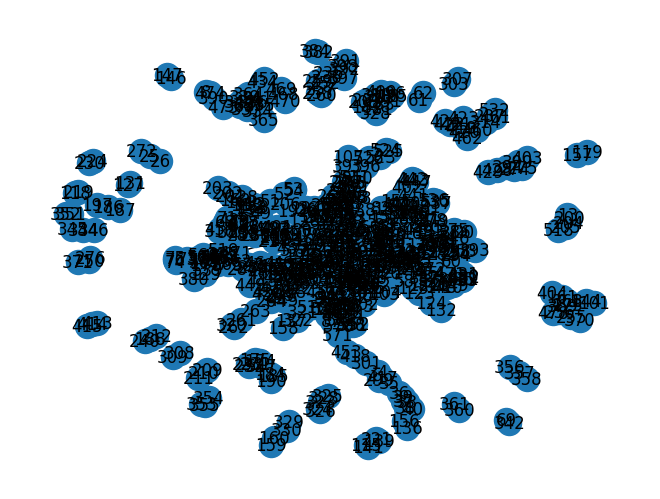

In [ ]:

import igraph as ig

# Taking the first graph for visualization
G = parsed_discussion_graphs[0]

# Converting calculated metrics to a form usable for visualization
visual_style = {}
degree_centrality = G.degree()
visual_style["vertex_size"] = [x * 10 for x in degree_centrality]

# Ploting the graph

import networkx as nx

# G is the iGraph graph
G_nx = nx.Graph(G.get_edgelist())


nx.draw(G_nx, with_labels=True)
plt.show()


### Exploring a Subsample

In [ ]:
import random

num_nodes_to_sample = 50
all_nodes = list(G_nx.nodes())
sampled_nodes = random.sample(all_nodes, num_nodes_to_sample)

# Creating subgraph
subgraph = G_nx.subgraph(sampled_nodes)

#nx.draw(subgraph, with_labels=True)
#plt.show()


#### Basic Plots

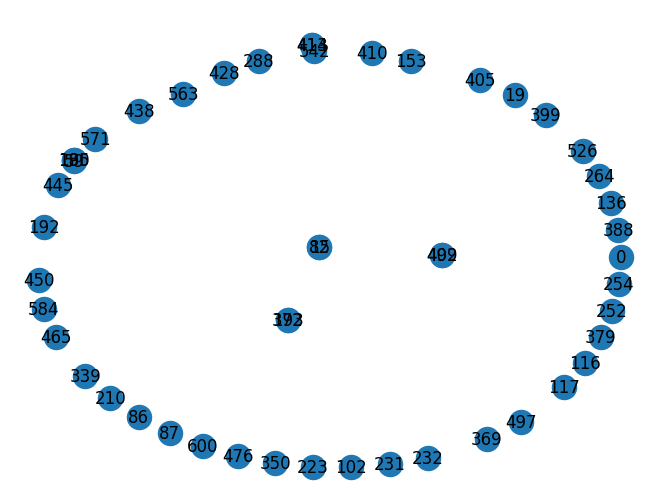

In [ ]:
# Drawing the subgraph using the Kamada-Kaway layout in order to get a better looking graph
pos = nx.kamada_kawai_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True)


plt.show()


In the visualization, the terms "Force-Directed X" and "Force-Directed Y" refer to the X and Y coordinates of each node in the graph as determined by a force-directed layout algorithm, specifically the Kamada-Kawai algorithm in this case. This algorithm arranges the nodes in a way that tries to balance two forces:

- *Attraction*: Nodes that are connected by an edge are pulled closer to each other.
- *Repulsion*: Nodes repel each other so they don't overlap.  

The **resulting coordinates don't represent any real-world measure** like distance or time but provide a spatial representation of the relationships between nodes, making it easier to interpret the graph structure.

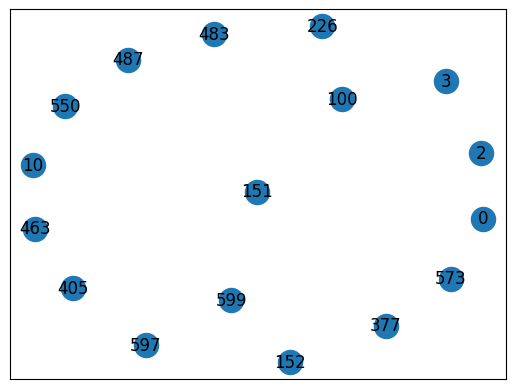

In [ ]:
# Finding a central node (e.g., the node with the highest degree centrality)
central_node = max(nx.degree_centrality(G_nx), key=nx.degree_centrality(G_nx).get)

# Finding neighbors of the central node
neighbors = list(G_nx.neighbors(central_node))

# Including the central node in the list
neighbors.append(central_node)

# Creating a subgraph around the central node
subgraph = G_nx.subgraph(neighbors)

# Drawing the subgraph
pos = nx.kamada_kawai_layout(subgraph)

# Drawing nodes
nx.draw_networkx_nodes(subgraph, pos)

# Drawing edges based on 'relation' attribute
edges_positive = [(u, v) for (u, v, d) in subgraph.edges(data=True) if d.get('relation') == 1]
edges_negative = [(u, v) for (u, v, d) in subgraph.edges(data=True) if d.get('relation') == -1]

nx.draw_networkx_edges(subgraph, pos, edgelist=edges_positive, edge_color='g')
nx.draw_networkx_edges(subgraph, pos, edgelist=edges_negative, edge_color='r')

# Adding position labels
nx.draw_networkx_labels(subgraph, pos)

plt.show()


In [ ]:
# Custom labels for textual representation
custom_labels = {}
central_node_text = G_nx.nodes[central_node].get('name', {}).get('text', central_node)
custom_labels[central_node] = f'Central Node/Theme: {central_node_text}'
print(custom_labels[central_node])
print()
print()
# Sample 1 pro and 1 con argument
pro_node = next((u for u, v, d in subgraph.edges(data=True) if d.get('relation') == 1), None)
con_node = next((u for u, v, d in subgraph.edges(data=True) if d.get('relation') == -1), None)

if pro_node:
    pro_text = G_nx.nodes[pro_node].get('name', {}).get('text', pro_node)
    custom_labels[pro_node] = f'Pro Claim: {pro_text}'

if con_node:
    con_text = G_nx.nodes[con_node].get('name', {}).get('text', pro_node)
    custom_labels[con_node] = f'Con Claim: {con_text}'

print(custom_labels[pro_node])
print()
print( custom_labels[con_node])

Central Node/Theme: 151


KeyError: ignored

In [ ]:
# Shortened text version for visualizing
custom_labels = {}
central_node_text = G_nx.nodes[central_node].get('name', {}).get('text', central_node)
custom_labels[central_node] = f'{central_node_text[:30]}...'

if pro_node:
    pro_text = G_nx.nodes[pro_node].get('name', {}).get('text', pro_node)
    custom_labels[pro_node] = f'+:{pro_text[:30]}...'

if con_node:
    con_text = G_nx.nodes[con_node].get('name', {}).get('text', con_node)
    custom_labels[con_node] = f'-:{con_text[:30]}...'


pos = nx.kamada_kawai_layout(subgraph)
nx.draw_networkx_nodes(subgraph, pos)
nx.draw_networkx_edges(subgraph, pos, edgelist=edges_positive, edge_color='g')
nx.draw_networkx_edges(subgraph, pos, edgelist=edges_negative, edge_color='r')


nx.draw_networkx_labels(subgraph, pos, labels=custom_labels)

plt.show()



TypeError: ignored

In [ ]:
G_nx.nodes[pro_node]

KeyError: ignored

#### Interactive 3D Plot of 2 independent subsampled graphs

In [ ]:
import plotly.graph_objects as go
import numpy as np

# 3D layout
pos_3d = nx.kamada_kawai_layout(subgraph, dim=3)

# Nodes
x_nodes = np.array([pos_3d[k][0] for k in pos_3d.keys()])
y_nodes = np.array([pos_3d[k][1] for k in pos_3d.keys()])
z_nodes = np.array([pos_3d[k][2] for k in pos_3d.keys()])

# Edges
x_edges = []
y_edges = []
z_edges = []

for edge in subgraph.edges(data=True):
    x0, y0, z0 = pos_3d[edge[0]]
    x1, y1, z1 = pos_3d[edge[1]]
    x_edges.extend([x0, x1, None])
    y_edges.extend([y0, y1, None])
    z_edges.extend([z0, z1, None])

# Creating scatter plot for edges
edge_trace = go.Scatter3d(
    x=x_edges,
    y=y_edges,
    z=z_edges,
    mode='lines',
    line=dict(width=1),
    hoverinfo='none'
)

# Creating scatter plot for nodes
node_trace = go.Scatter3d(
    x=x_nodes,
    y=y_nodes,
    z=z_nodes,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        size=6
    )
)

# Creatig 3D network graph
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(scene=dict(aspectmode="cube"))


fig.show()


In [ ]:
import plotly.graph_objects as go

def visualize_igraph_3d(graph):
    layout = graph.layout('kk', dim=3)
    Xn = [layout[i][0] for i in range(len(layout))]
    Yn = [layout[i][1] for i in range(len(layout))]
    Zn = [layout[i][2] for i in range(len(layout))]
    Xe = []
    Ye = []
    Ze = []
    for edge in graph.es:
        Xe += [layout[edge.source][0], layout[edge.target][0], None]
        Ye += [layout[edge.source][1], layout[edge.target][1], None]
        Ze += [layout[edge.source][2], layout[edge.target][2], None]

    trace1 = go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='gray', width=0.5))
    trace2 = go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', marker=dict(size=5, color='red'))

    fig = go.Figure(data=[trace1, trace2])
    fig.update_layout(scene=dict(aspectmode="cube"))
    fig.show()

# Visualizing subgraphs
visualize_igraph_3d(parsed_discussion_graphs[0])
visualize_igraph_3d(parsed_discussion_graphs[1])

#### Top View Graph for subsampled number of themes

In [ ]:
def plot_multiple_graphs(graphs, num_graphs):
    plt.figure(figsize=(12,12))

    color_map = plt.colormaps['tab10']

    offset_x, offset_y = 0, 0
    for i, graph in enumerate(graphs[:num_graphs]):
        layout = graph.layout('kk')
        x = np.array(layout.coords)[:,0] + offset_x
        y = np.array(layout.coords)[:,1] + offset_y

        # Draw nodes
        plt.scatter(x, y, c=[color_map(i / num_graphs) for _ in range(len(x))], label=f"Theme {i+1}")

        # Draw edges
        for edge in graph.es:
            x_values = [layout.coords[edge.source][0] + offset_x, layout.coords[edge.target][0] + offset_x]
            y_values = [layout.coords[edge.source][1] + offset_y, layout.coords[edge.target][1] + offset_y]
            plt.plot(x_values, y_values, color='gray')

        offset_x += 50  # Update offset for next graph

    plt.xlabel("Force-Directed X")
    plt.ylabel("Force-Directed Y")
    plt.ylim(-100, plt.ylim()[1])  # Restrict Y-axis
    plt.legend()
    plt.title(f'{num_graphs} Subsampled Graphs - Top View')
    plt.show()
# Call the function again
plot_multiple_graphs(parsed_discussion_graphs, num_graphs=5)


### Subgraphs Within the Same Theme

In [ ]:
def find_root_claim(island_graph):
    """
    Identifies the root claim (node with highest in-degree) in an island/subgraph.
    Assumes that the graph is directed and that the root has the highest in-degree.
    """
    in_degrees = island_graph.indegree()
    root_index = in_degrees.index(max(in_degrees))
    root_claim = island_graph.vs[root_index]['name']['text']
    return root_claim

# Assuming you have the actual igraph objects for the two largest islands as `largest_island` and `second_largest_island`
root_claim_largest_island = find_root_claim(largest_island)
root_claim_second_largest_island = find_root_claim(second_largest_island)

print("Root claim of the largest island:", root_claim_largest_island)
print("Root claim of the second largest island:", root_claim_second_largest_island)


In [ ]:
# Identifying disconnected subgraphs (islands) within Theme 1
subgraphs = parsed_discussion_graphs[0].decompose()
print("Number of subgraphs: ", len(subgraphs))
# Calculate centrality measures for each island
for i, subgraph in enumerate(subgraphs):
    print(f"Island {i+1}")
    print("Degree Centrality:", np.mean(subgraph.degree()))
    print("Closeness Centrality:", np.mean(subgraph.closeness()))
    print("Betweenness Centrality:", np.mean(subgraph.betweenness()))


In [ ]:

root_node_second_island = second_largest_island.vs[0]
out_degree_root_second = root_node_second_island.outdegree()

print(f"Out-degree of the root node of the second largest island: {out_degree_root_second}")
if out_degree_root_second == 0:
    print("The root node of the second island has no outgoing edges. Likely unrelated.")
else:
    print("The root node of the second island has outgoing edges. Further investigation needed.")


In [ ]:
# Checking for mislabeling by considering titles at the X.1 position
mislabel_check = any(
    graph.vs[1]['name']['text'] == root_node_second_island['name']['text'] for graph in parsed_discussion_graphs if graph is not None and len(graph.vs) > 1
)
print(f"Is the second island mislabeled? {'Yes' if mislabel_check else 'No'}")


In [ ]:
def get_top_n_islands(subgraphs, centrality_measure='betweenness', n=2):
    """function to get top n islands based on betweenness centrality"""
    centrality_data = []
    for i, subgraph in enumerate(subgraphs):
        centrality_data.append({
            'index': i,
            'degree': np.mean(subgraph.degree()),
            'closeness': np.mean(subgraph.closeness()),
            'betweenness': np.mean(subgraph.betweenness())
        })

    sorted_islands = sorted(centrality_data, key=lambda x: x[centrality_measure], reverse=True)
    top_n_indices = [sorted_islands[i]['index'] for i in range(n)]

    return [subgraphs[i] for i in top_n_indices]


In [ ]:
# Function to fetch claim texts from the nodes of a graph
def fetch_claims_from_graph(graph, n=5):
    return [v['name']['text'] for v in graph.vs][:n]

# Fetch the claims for the two largest islands
largest_island_claims = fetch_claims_from_graph(top_2_islands[0], n=5)
second_largest_island_claims = fetch_claims_from_graph(top_2_islands[1], n=5)

print("1st largest island first 5 claims:")
print()
for claim1 in largest_island_claims:
  print(claim1)
print()
print()
print()
print("2nd largest island first 5 claims:")
print()
print("[COMMENT THAT TRIGGERED THE DEVIATING CONVERSATION]")   #TODO : Find this comment, investigate further
for claim2 in second_largest_island_claims:
  print(claim2)

In [ ]:
from collections import Counter
import re

def extract_keywords(claims, n=5):
    """Function to extract keywords from a list of claims"""
    text = " ".join(claims)
    words = re.findall(r'\w+', text.lower())  # Convert text to lower case and split into words
    counter = Counter(words)

    return counter.most_common(n)

# Get top 5 keywords for each of the top 2 islands
largest_island_top_keywords = extract_keywords(largest_island_claims)
second_largest_island_top_keywords = extract_keywords(second_largest_island_claims)

print("Top 5 keywords in the largest island:", largest_island_top_keywords)
print("Top 5 keywords in the second largest island:", second_largest_island_top_keywords)



#### Conclusions And Next Steps of Subgraph-Analysis

#### Disconnected Sub-discussions
Within a central theme (e.g., "Cryptocurrencies are beneficial"), multiple disconnected islands can emerge. These islands appear to be self-contained discussions not directly related to the central root claim.

#### Divergent Root Claims
These islands can have root claims that are significantly different from the central theme, suggesting that they represent divergent sub-discussions.

#### Not Mislabelled
Checks confirmed that the islands are not results of data mislabeling; they are genuinely part of the same overarching discussion.

#### Unclear Causes
The reasons for the formation of such disconnected islands within the same overarching discussion are not entirely clear. It could be due to a loss of relations between nodes or a natural divergence of discussion topics.

### Open Points (TODO)
- Further investigation is needed to determine whether relations between nodes got lost (before or after filtering/parsing the graph from the JSON structure) or if these are genuinely divergent discussions.
- Text-level analysis could provide more insights into how and why these sub-discussions diverge so significantly.
---



---



In [ ]:
"""
def check_graph_community_consistency(graph, community):
  "function to check if the community list and graphs refer to same ids"
    # Extracting 'id' from nested 'name' attribute in graph
    graph_vertex_ids = set(v['name']['id'] for v in graph.vs)
    print(graph_vertex_ids[0])

    # Extract 'id' attributes from vertices in all community subgraphs
    for subgraph in community.subgraphs():
          print(subgraph.vs["name"][0]["id"])
          break

    return graph_vertex_ids == community_vertex_ids


community = theme1_communities
is_consistent = check_graph_community_consistency(theme1_graph, community)"""


In [ ]:
subgraph.vs["name"][0]["id"]

## Investigating Outliers

Find all outliers in the graphs based on **z-score using 3 standard deviations** as default

In [ ]:
# Finding the outlier node and its graph from the 5 visualized graphs

import numpy as np

# Initialize lists to store coordinates and node IDs
all_coordinates = []
all_node_ids = []

# Loop through the first 5 graphs
for i, graph in enumerate(parsed_discussion_graphs[:5]):
    layout = graph.layout("kk")
    coordinates = np.array(layout.coords)
    node_ids = [v.index for v in graph.vs]

    all_coordinates.extend(coordinates)
    all_node_ids.extend([(i, id) for id in node_ids])

# Convert list of coordinates to NumPy array
all_coordinates = np.array(all_coordinates)

# Calculate the mean and standard deviation of the coordinates
mean_coord = np.mean(all_coordinates, axis=0)
std_coord = np.std(all_coordinates, axis=0)

# Identify outliers based on z-score (here using 3 standard deviations as a threshold)
outliers = np.where(np.abs(all_coordinates - mean_coord) > 3 * std_coord)
outlier_indices = np.unique(outliers[0])

# Extract information about the outlier nodes
outlier_info = [all_node_ids[i] for i in outlier_indices]

outlier_info


In [ ]:
# for all outliers (takes very long to run)

"""
all_coordinates = []
all_node_ids = []
all_outlier_gidx_nid =[]
# Loop through parsed_discussion_graphs
for i, graph in enumerate(parsed_discussion_graphs):
    layout = graph.layout("kk")
    coordinates = np.array(layout.coords)
    node_ids = [v.index for v in graph.vs]

    all_coordinates.extend(coordinates)
    all_node_ids.extend([(i, id) for id in node_ids])

all_coordinates = np.array(all_coordinates)

# Calculate mean and standard deviation
mean_coord = np.mean(all_coordinates, axis=0)
std_coord = np.std(all_coordinates, axis=0)

# Find outlier
outliers = np.where(np.abs(all_coordinates - mean_coord) > 3 * std_coord)
outlier_indices = np.unique(outliers[0])

outlier_info = [all_node_ids[i] for i in outlier_indices]
print("Outliers found in the following graphs and nodes:")
for graph_idx, node_id in outlier_info:
    print(f"Graph Index: {graph_idx}, Node ID: {node_id}")
    all_outlier_gidx_nid.append((graph_idx,node_id))
"""

Assuming outlier_graph_index is the index of the outlier graph and outlier_node_id is the ID of the outlier node

In [ ]:
def investigate_outlier_node(graphs, outlier_graph_index, outlier_node_id, theme_node_id):
    """
    Investigates a given node in a given graph.

    Parameters:
    - graphs: list of igraph.Graph objects
    - graph_index: index of the graph in the list where the node is located
    - node_id: ID of the node to investigate

    Returns:
    None
    """
    graph = graphs[outlier_graph_index]  # Get the graph object based on the index

    # Find theme node and outlier node by iterating through the graph's nodes
    theme_node, outlier_node = None, None
    for node in graph.vs:
        if node.index == theme_node_id:
            theme_node = node
        if node.index == outlier_node_id:
            outlier_node = node
        if theme_node and outlier_node:
            break

    if theme_node:
        print(f"Theme Node Info: {theme_node.attributes()}")
        print()
    else:
        print("Theme node not found.")

    if outlier_node is None:
        print("Outlier node not found.")
        return

    # Find related nodes (both parent and child)
    related_nodes = graph.neighbors(outlier_node, mode='all')

    # Nodes directly responded to by the outlier
    parent_nodes = graph.neighbors(outlier_node, mode='in')

    # Sort related nodes to maintain a logical conversation order
    sorted_related_nodes = sorted(related_nodes)

    # Print outlier and related nodes
    print(f"Outlier Node Info: {outlier_node.attributes()}")
    for node_id in sorted_related_nodes:
        node = graph.vs[node_id]
        additional_text = " (responded to by outlier)" if node_id in parent_nodes else ""
        print(f"Related Node Info: {node.attributes()}{additional_text}")

# Investigate the first three outlier nodes for demonstration
for theme_idx, node_idx, theme_node_idx in [(3, 514, 151), (2, 9, 151), (2, 10, 151)]:
    print(f"Investigating Outlier-Node {node_idx} in Theme {theme_idx + 1}")
    print("="*50)
    investigate_outlier_node(parsed_discussion_graphs, theme_idx, node_idx, theme_node_idx)
    print("\n")


##### Conclusion: Identifying Outliers (Part 1)

Based on our investigations, we hypothesize that an outlier is a claim that deviates significantly from the common themes or perspectives within a discussion. Here are a few examples:

<br/>
    
     
   
#### Outlier 1: 801.2113
**Point:** Scientific evidence against capital punishment.

**Why Unconventional:** While most claims in the discussion focus on the ethical or legal aspects of capital punishment, this claim introduces a scientific perspective, making it an outlier in a predominantly ethics-based discussion.


---


#### Outlier 2: 486.10
**Point:** Questioning the defensive nature of military equipment.

**Why Unconventional:** This claim deviates from the common discussion around the utility or morality of autonomous killing machines (AKMs). Instead, it questions the basic premise of what counts as "defensive," challenging the framing of the entire discussion.


---



#### Outlier 3: 486.11
**Point:** Combining ethical and practical concerns about autonomous systems.

**Why Unconventional:** While many claims address either the ethical implications or the functional utility of AKMs, this claim uniquely combines both aspects, making it an outlier.

---
<br/>
<br/>

**Note:** Further investigation may be needed to fully understand the unique characteristics of these outlier points. (TODO)


# Candidate Features to Probe

***(order is still irrelevant)***

Following features can potentially used to probe the ability of language models to follow discussions:
## 1. Discussion Structure (Depth and Breadth)
**Relevance**: Understanding the structural complexity of discussions is crucial for designing tests for Language Models (LLMs). For instance, deeper discussions may require more advanced attention mechanisms in the models.

## 2. Author Engagement (Multiple Discussions)
**Relevance**: Evaluating whether authors engage in multiple discussions is important for assessing a model's ability to follow context switches or diversify topics.

## 3. Discussion Balance (Pro vs Con)
**Relevance**: If discussions are highly polarized, LLMs should be capable of recognizing and adapting to these stances.

## 4. Author Dominance
**Relevance**: Identifying dominant authors is crucial for understanding potential biases in the data, which LLMs might inherit.

## 5. Discussion Evolution (Time Analysis)
**Relevance**: Tracking how discussions evolve over time is important for LLMs to understand the flow and relevance of claims.

## 6. Response Time
**Relevance**: The speed of responses, whether quick or delayed, could indicate the urgency or thoughtfulness required in a discussion, a feature LLMs should ideally recognize.

## 7. Topic Clustering
**Relevance**: Understanding the major themes in the dataset allows us to tailor LLM probing tasks more effectively.


---

## 8. Subgraphs
 a probing task could be to test a model's ability to identify whether two claims are part of the same discussion sub-thread or not.

Probing Task: "Are these claims part of the same sub-discussion?"
Data Preparation:

X: Pairs of claims (node texts) from the graph.
y: Label indicating if they are part of the same island (1) or different islands (0).

## 9. Pro Base Claim or Con Base Claim  

sind 2 claims gegen oder für einander ?
claim mit Tiefe (Diskussion mit versch. Tiefen - Normalisierung ? da tiefe 4 bei einem task fein granulierter als 10 in einem anderen)
Sind 2 claims auf dem selben Level ?

kann das modell verschiedene tiefenebenen erkennen ?
shortest path?
2 claims mit distanz 2 : sind sie für oder gegneinander: PROBE dynamich gestalten, wir können auch probe mit länge 3, 4 // je weiter auseinander je mehr anders (generell) nicht immer.

von gleicher diskussion oder nicht ?

2-3 claims + base node // sind nodes/claims antworten oder nicht ?

start oder endclaim ? oder basisclaim?


csv - format (speziell) Daten abspeichern, das kann nachher direkt dem Classifier trainiert werden und reporten.

Probing: Visualisieren --- visio/konzeptionell > input , von wo kommt das label / black box



In [ ]:
# Find root claim based on in-degree
def find_root_claim(discussion_graph):
    in_degrees = discussion_graph.indegree()
    return in_degrees.index(max(in_degrees)) #0.1 (ist das so?, kein INgoing edges)

# Extract claims and their depths
def extract_claims_with_depth(discussion_graph, output_file):
    root_claim_index = find_root_claim(discussion_graph)
    stack = [(discussion_graph.vs[root_claim_index], 0)]

    with open(output_file, "ab") as f: # shortest path
        while stack:
            current_node, current_depth = stack.pop()
            claim_data = (current_node['name']['text'], current_depth)
            pickle.dump(claim_data, f)

            for neighbor_index in discussion_graph.successors(current_node.index):
                stack.append((discussion_graph.vs[neighbor_index], current_depth + 1))

    gc.collect()

# Process all graphs
def process_all_graphs(discussion_graphs, batch_size=1):
    for i, graph in enumerate(discussion_graphs):
        if graph is not None:
            output_file = f"claims_with_depth_batch_{i+1}.pkl"
            extract_claims_with_depth(graph, output_file)

        if (i + 1) % batch_size == 0:
            gc.collect()

# Replace this with your list of graphs
parsed_discussion_graphs = [your_parsed_graphs_here]

# Process all graphs
process_all_graphs(parsed_discussion_graphs)


In [ ]:
# OUT OF MEMORY (RAM) ISSUE ON 51.0 GB LIMIT


# Iterative DFS to find depths
def extract_claims_with_depth(discussion_graph):
    claims_with_depth = []
    stack = []
    root_claim_index = find_root_claim(discussion_graph)
    stack.append((discussion_graph.vs[root_claim_index], 0))

    while stack:
        current_node, current_depth = stack.pop()
        claims_with_depth.append((current_node['name']['text'], current_depth))

        for neighbor_index in discussion_graph.successors(current_node.index):
            stack.append((discussion_graph.vs[neighbor_index], current_depth + 1))

    return claims_with_depth

# Function to find the root claim in a graph
def find_root_claim(discussion_graph):
    in_degrees = discussion_graph.indegree()
    return in_degrees.index(max(in_degrees))

# Process all graphs and save the claims and their depths
def extract_claims_with_depth_all_graphs(discussion_graphs, batch_size=5):
    batch = []
    for i, graph in enumerate(discussion_graphs):
        if graph:
            batch.append(extract_claims_with_depth(graph))

        # Save the current batch and clear memory
        if (i + 1) % batch_size == 0:
            with open(f"claims_with_depth_batch_{i//batch_size + 1}.pkl", "wb") as f:
                pickle.dump(batch, f)
            batch = []
            gc.collect()

# Sample discussion graphs (replace this with your actual data)
sample_graphs = parsed_discussion_graphs

# Extract and save the claims with depths
extract_claims_with_depth_all_graphs(sample_graphs)


In [ ]:
# OUT OF MEMORY (RAM) ISSUE ON 51.0 GB LIMIT
import gc  # garbage collection
import pickle

def extract_claims_with_depth_all_graphs(discussion_graphs, save_path, batch_size=1):
    batch_count = 0

    for discussion_graph in discussion_graphs:
        if discussion_graph is None:
            continue

        stack = []
        claims_with_depth = []

        root_claim_index = discussion_graph.indegree().index(max(discussion_graph.indegree()))
        stack.append((discussion_graph.vs[root_claim_index], 0))

        while stack:
            node, depth = stack.pop()
            claims_with_depth.append((node['name']['text'], depth))

            for neighbor_index in discussion_graph.successors(node.index):
                stack.append((discussion_graph.vs[neighbor_index], depth + 1))

        batch_count += 1
        if batch_count % batch_size == 0:
            with open(f"{save_path}_batch_{batch_count}.pkl", "wb") as f:
                pickle.dump(claims_with_depth, f)

            claims_with_depth.clear()  # Clear the list
            gc.collect()  # Run garbage collection

save_path = "/content/drive/MyDrive/Can Language Models Follow Discussions?/Data - kialo.com/all_claims_with_depth"
extract_claims_with_depth_all_graphs(parsed_discussion_graphs, save_path)

